In [1]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.0/841.0 kB 26.5 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-0.2.6-cp310-cp310-linux_x86_64.whl size=203240 sha256=0f44961c0993d7ac8b8f064713ae96ac7ac43a085dcbb7bd598ef8e065481f09
  Stored in directory: /root/.cache/pip/wheels/c0/8d/68/ba5928fd2294d4abf68eb22f025c36943d9a55eb0149763589
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
  Created wheel for nes

In [2]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
from google.colab import output

In [3]:
# Makes a series of transformations to environment to improve learning. Repeats action for 4 frame, reduces frame size,
# Normalizes frame pixel values, and limits number of actions agent can take (can only move right).  
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        """teps through RL training -- computes observed state and reward and updates """
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

def make_env(env):
    '''
    Takes in gym_super_mario_bros environment and returns simplified environment
    '''
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#implements double q-learning 
class DQNSolver(nn.Module):
    '''
    Class for Double Q Learning model
    '''
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:
    '''
    Class for Double Q Learning agent
    '''
    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [5]:
def vectorize_action(action, action_space):
    '''
    Given a scalar action, return a one-hot encoded action
    '''
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [15]:
filenames = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def show_state(env, frame, ep=0, info=""):
    '''
    Plots state of environment and saves images
    '''
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')
    filename = f'{frame}.png'
    filenames.append(filename)
    plt.savefig(filename)


    #output.clear()
    #plt.show()


    #display.clear_output(wait=True)
    #display.display(plt.gcf())

In [17]:
def run(training_mode, pretrained):
    '''
    Creates and runs Gym environment
    training_mode input (boolean) determines whether to train the model while running
    '''
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')

    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)
    
    num_episodes = 100
    env.reset()
    total_rewards = []
    frame = 0
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, frame, ep_num)
                frame += 1
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
    
    if num_episodes > 500:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(500)] + 
                 np.convolve(total_rewards, np.ones((500,))/500, mode="valid").tolist())
        plt.show()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-8-75896b8eaaf4>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to 

Total reward after episode 1 is 638.0


  1%|          | 2/300 [00:34<1:26:16, 17.37s/it]

Total reward after episode 2 is 617.0


  1%|          | 3/300 [00:58<1:42:00, 20.61s/it]

Total reward after episode 3 is 631.0


  1%|▏         | 4/300 [01:03<1:11:06, 14.41s/it]

Total reward after episode 4 is 245.0


  2%|▏         | 5/300 [01:26<1:26:31, 17.60s/it]

Total reward after episode 5 is 747.0


  2%|▏         | 6/300 [01:32<1:07:01, 13.68s/it]

Total reward after episode 6 is 232.0


  2%|▏         | 7/300 [01:37<52:05, 10.67s/it]  

Total reward after episode 7 is 250.0


  3%|▎         | 8/300 [01:41<41:47,  8.59s/it]

Total reward after episode 8 is 251.0


  3%|▎         | 9/300 [01:45<34:45,  7.17s/it]

Total reward after episode 9 is 252.0


  3%|▎         | 10/300 [01:48<29:14,  6.05s/it]

Total reward after episode 10 is 248.0


  4%|▎         | 11/300 [01:54<27:46,  5.77s/it]

Total reward after episode 11 is 248.0


  4%|▍         | 12/300 [01:58<25:35,  5.33s/it]

Total reward after episode 12 is 251.0


  4%|▍         | 13/300 [02:02<23:07,  4.83s/it]

Total reward after episode 13 is 251.0


  5%|▍         | 14/300 [02:05<21:18,  4.47s/it]

Total reward after episode 14 is 248.0


  5%|▌         | 15/300 [02:10<21:36,  4.55s/it]

Total reward after episode 15 is 251.0


  5%|▌         | 16/300 [02:14<20:12,  4.27s/it]

Total reward after episode 16 is 251.0


  6%|▌         | 17/300 [02:17<19:13,  4.08s/it]

Total reward after episode 17 is 248.0


  6%|▌         | 18/300 [02:22<20:03,  4.27s/it]

Total reward after episode 18 is 251.0


  6%|▋         | 19/300 [02:25<19:01,  4.06s/it]

Total reward after episode 19 is 251.0


  7%|▋         | 20/300 [02:29<18:22,  3.94s/it]

Total reward after episode 20 is 251.0


  7%|▋         | 21/300 [02:34<19:11,  4.13s/it]

Total reward after episode 21 is 251.0


  7%|▋         | 22/300 [02:37<18:37,  4.02s/it]

Total reward after episode 22 is 251.0


  8%|▊         | 23/300 [02:41<18:01,  3.90s/it]

Total reward after episode 23 is 251.0


  8%|▊         | 24/300 [02:45<17:50,  3.88s/it]

Total reward after episode 24 is 248.0


  8%|▊         | 25/300 [02:49<18:33,  4.05s/it]

Total reward after episode 25 is 251.0


  9%|▊         | 26/300 [02:53<18:30,  4.05s/it]

Total reward after episode 26 is 238.0


  9%|▉         | 27/300 [02:57<18:02,  3.96s/it]

Total reward after episode 27 is 251.0


  9%|▉         | 28/300 [03:02<18:59,  4.19s/it]

Total reward after episode 28 is 248.0


 10%|▉         | 29/300 [03:06<18:12,  4.03s/it]

Total reward after episode 29 is 251.0


 10%|█         | 30/300 [03:09<17:49,  3.96s/it]

Total reward after episode 30 is 247.0


 10%|█         | 31/300 [03:14<19:04,  4.26s/it]

Total reward after episode 31 is 247.0


 11%|█         | 32/300 [03:18<18:16,  4.09s/it]

Total reward after episode 32 is 251.0


 11%|█         | 33/300 [03:22<17:41,  3.98s/it]

Total reward after episode 33 is 248.0


 11%|█▏        | 34/300 [03:27<18:45,  4.23s/it]

Total reward after episode 34 is 251.0


 12%|█▏        | 35/300 [03:30<17:45,  4.02s/it]

Total reward after episode 35 is 252.0


 12%|█▏        | 36/300 [03:34<17:15,  3.92s/it]

Total reward after episode 36 is 251.0


 12%|█▏        | 37/300 [03:39<18:29,  4.22s/it]

Total reward after episode 37 is 248.0


 13%|█▎        | 38/300 [03:42<17:42,  4.05s/it]

Total reward after episode 38 is 252.0


 13%|█▎        | 39/300 [03:46<17:10,  3.95s/it]

Total reward after episode 39 is 250.0


 13%|█▎        | 40/300 [03:50<17:23,  4.01s/it]

Total reward after episode 40 is 252.0


 14%|█▎        | 41/300 [03:54<17:34,  4.07s/it]

Total reward after episode 41 is 251.0


 14%|█▍        | 42/300 [03:58<16:52,  3.92s/it]

Total reward after episode 42 is 250.0


 14%|█▍        | 43/300 [04:02<16:35,  3.87s/it]

Total reward after episode 43 is 249.0


 15%|█▍        | 44/300 [04:07<17:57,  4.21s/it]

Total reward after episode 44 is 251.0


 15%|█▌        | 45/300 [04:10<17:16,  4.06s/it]

Total reward after episode 45 is 250.0


 15%|█▌        | 46/300 [04:14<16:42,  3.95s/it]

Total reward after episode 46 is 250.0


 16%|█▌        | 47/300 [04:19<17:51,  4.24s/it]

Total reward after episode 47 is 250.0


 16%|█▌        | 48/300 [04:42<41:36,  9.91s/it]

Total reward after episode 48 is 779.0


 16%|█▋        | 49/300 [04:46<34:18,  8.20s/it]

Total reward after episode 49 is 251.0


 17%|█▋        | 50/300 [05:21<1:06:48, 16.03s/it]

Total reward after episode 50 is 796.0


 17%|█▋        | 51/300 [05:25<51:48, 12.48s/it]  

Total reward after episode 51 is 251.0


 17%|█▋        | 52/300 [05:55<1:13:29, 17.78s/it]

Total reward after episode 52 is 1034.0


 18%|█▊        | 53/300 [06:37<1:43:33, 25.16s/it]

Total reward after episode 53 is 1300.0


 18%|█▊        | 54/300 [06:59<1:38:22, 23.99s/it]

Total reward after episode 54 is 638.0


 18%|█▊        | 55/300 [07:30<1:46:57, 26.20s/it]

Total reward after episode 55 is 801.0


 19%|█▊        | 56/300 [07:49<1:37:52, 24.07s/it]

Total reward after episode 56 is 817.0


 19%|█▉        | 57/300 [08:13<1:36:44, 23.89s/it]

Total reward after episode 57 is 812.0


 19%|█▉        | 58/300 [08:30<1:28:00, 21.82s/it]

Total reward after episode 58 is 820.0


 20%|█▉        | 59/300 [08:50<1:25:26, 21.27s/it]

Total reward after episode 59 is 817.0


 20%|██        | 60/300 [09:00<1:12:13, 18.06s/it]

Total reward after episode 60 is 636.0


 20%|██        | 61/300 [09:26<1:20:46, 20.28s/it]

Total reward after episode 61 is 818.0


 21%|██        | 62/300 [09:36<1:08:56, 17.38s/it]

Total reward after episode 62 is 625.0


 21%|██        | 63/300 [09:47<1:01:12, 15.49s/it]

Total reward after episode 63 is 625.0


 21%|██▏       | 64/300 [10:08<1:07:27, 17.15s/it]

Total reward after episode 64 is 640.0


 22%|██▏       | 65/300 [10:13<52:24, 13.38s/it]  

Total reward after episode 65 is 241.0


 22%|██▏       | 66/300 [10:39<1:06:30, 17.05s/it]

Total reward after episode 66 is 1037.0


 22%|██▏       | 67/300 [10:43<51:41, 13.31s/it]  

Total reward after episode 67 is 237.0


 23%|██▎       | 68/300 [11:04<59:59, 15.51s/it]

Total reward after episode 68 is 1357.0


 23%|██▎       | 69/300 [11:08<46:11, 12.00s/it]

Total reward after episode 69 is 249.0


 23%|██▎       | 70/300 [11:32<59:57, 15.64s/it]

Total reward after episode 70 is 1584.0


 24%|██▎       | 71/300 [11:42<53:11, 13.94s/it]

Total reward after episode 71 is 625.0


 24%|██▍       | 72/300 [11:50<46:53, 12.34s/it]

Total reward after episode 72 is 611.0


 24%|██▍       | 73/300 [12:09<53:57, 14.26s/it]

Total reward after episode 73 is 818.0


 25%|██▍       | 74/300 [12:19<49:10, 13.05s/it]

Total reward after episode 74 is 654.0


 25%|██▌       | 75/300 [12:29<45:12, 12.05s/it]

Total reward after episode 75 is 654.0


 25%|██▌       | 76/300 [12:33<36:18,  9.73s/it]

Total reward after episode 76 is 246.0


 26%|██▌       | 77/300 [12:43<36:27,  9.81s/it]

Total reward after episode 77 is 627.0


 26%|██▌       | 78/300 [12:55<37:54, 10.25s/it]

Total reward after episode 78 is 651.0


 26%|██▋       | 79/300 [13:10<43:35, 11.84s/it]

Total reward after episode 79 is 620.0


 27%|██▋       | 80/300 [13:19<40:31, 11.05s/it]

Total reward after episode 80 is 654.0


 27%|██▋       | 81/300 [13:51<1:02:32, 17.13s/it]

Total reward after episode 81 is 1345.0


 27%|██▋       | 82/300 [14:02<56:29, 15.55s/it]  

Total reward after episode 82 is 622.0


 28%|██▊       | 83/300 [14:28<1:06:43, 18.45s/it]

Total reward after episode 83 is 809.0


 28%|██▊       | 84/300 [15:00<1:21:43, 22.70s/it]

Total reward after episode 84 is 1026.0


 28%|██▊       | 85/300 [15:32<1:31:28, 25.53s/it]

Total reward after episode 85 is 1028.0


 29%|██▊       | 86/300 [16:00<1:33:24, 26.19s/it]

Total reward after episode 86 is 1036.0


 29%|██▉       | 87/300 [16:31<1:37:58, 27.60s/it]

Total reward after episode 87 is 801.0


 29%|██▉       | 88/300 [16:41<1:19:06, 22.39s/it]

Total reward after episode 88 is 654.0


 30%|██▉       | 89/300 [17:02<1:17:16, 21.97s/it]

Total reward after episode 89 is 1047.0


 30%|███       | 90/300 [17:26<1:19:13, 22.63s/it]

Total reward after episode 90 is 1579.0


 30%|███       | 91/300 [17:41<1:09:58, 20.09s/it]

Total reward after episode 91 is 624.0


 31%|███       | 92/300 [18:00<1:08:32, 19.77s/it]

Total reward after episode 92 is 1048.0


 31%|███       | 93/300 [18:13<1:01:20, 17.78s/it]

Total reward after episode 93 is 633.0


 31%|███▏      | 94/300 [18:17<46:53, 13.66s/it]  

Total reward after episode 94 is 248.0


 32%|███▏      | 95/300 [18:37<53:50, 15.76s/it]

Total reward after episode 95 is 816.0


 32%|███▏      | 96/300 [18:48<47:53, 14.08s/it]

Total reward after episode 96 is 630.0


 32%|███▏      | 97/300 [19:27<1:13:45, 21.80s/it]

Total reward after episode 97 is 1018.0


 33%|███▎      | 98/300 [19:36<1:00:15, 17.90s/it]

Total reward after episode 98 is 610.0


 33%|███▎      | 99/300 [20:13<1:18:42, 23.50s/it]

Total reward after episode 99 is 1021.0


 33%|███▎      | 100/300 [20:30<1:11:41, 21.51s/it]

Total reward after episode 100 is 602.0


 34%|███▎      | 101/300 [20:35<54:59, 16.58s/it]  

Total reward after episode 101 is 236.0


 34%|███▍      | 102/300 [20:51<54:09, 16.41s/it]

Total reward after episode 102 is 1051.0


 34%|███▍      | 103/300 [20:56<42:50, 13.05s/it]

Total reward after episode 103 is 236.0


 35%|███▍      | 104/300 [21:10<43:23, 13.28s/it]

Total reward after episode 104 is 624.0


 35%|███▌      | 105/300 [21:33<52:57, 16.30s/it]

Total reward after episode 105 is 812.0


 35%|███▌      | 106/300 [21:55<57:51, 17.90s/it]

Total reward after episode 106 is 766.0


 36%|███▌      | 107/300 [22:08<52:42, 16.39s/it]

Total reward after episode 107 is 631.0


 36%|███▌      | 108/300 [22:21<49:15, 15.40s/it]

Total reward after episode 108 is 628.0


 36%|███▋      | 109/300 [22:42<54:31, 17.13s/it]

Total reward after episode 109 is 1044.0


 37%|███▋      | 110/300 [22:57<52:33, 16.60s/it]

Total reward after episode 110 is 1051.0


 37%|███▋      | 111/300 [23:09<47:42, 15.15s/it]

Total reward after episode 111 is 636.0


 37%|███▋      | 112/300 [23:13<37:14, 11.88s/it]

Total reward after episode 112 is 240.0


 38%|███▊      | 113/300 [23:24<35:28, 11.38s/it]

Total reward after episode 113 is 628.0


 38%|███▊      | 114/300 [23:27<28:07,  9.07s/it]

Total reward after episode 114 is 248.0


 38%|███▊      | 115/300 [23:55<44:52, 14.55s/it]

Total reward after episode 115 is 1036.0


 39%|███▊      | 116/300 [24:28<1:01:46, 20.15s/it]

Total reward after episode 116 is 799.0


 39%|███▉      | 117/300 [24:51<1:04:19, 21.09s/it]

Total reward after episode 117 is 1039.0


 39%|███▉      | 118/300 [25:42<1:30:48, 29.94s/it]

Total reward after episode 118 is 599.0


 40%|███▉      | 119/300 [25:50<1:11:14, 23.61s/it]

Total reward after episode 119 is 625.0


 40%|████      | 120/300 [27:08<1:59:34, 39.86s/it]

Total reward after episode 120 is 2312.0


 40%|████      | 121/300 [27:13<1:27:14, 29.24s/it]

Total reward after episode 121 is 252.0


 41%|████      | 122/300 [27:47<1:31:41, 30.91s/it]

Total reward after episode 122 is 1415.0


 41%|████      | 123/300 [28:05<1:19:38, 27.00s/it]

Total reward after episode 123 is 629.0


 41%|████▏     | 124/300 [28:47<1:31:51, 31.31s/it]

Total reward after episode 124 is 1134.0


 42%|████▏     | 125/300 [29:00<1:15:40, 25.95s/it]

Total reward after episode 125 is 628.0


 42%|████▏     | 126/300 [29:36<1:23:58, 28.96s/it]

Total reward after episode 126 is 1305.0


 42%|████▏     | 127/300 [30:08<1:26:15, 29.92s/it]

Total reward after episode 127 is 1311.0


 43%|████▎     | 128/300 [30:56<1:40:38, 35.11s/it]

Total reward after episode 128 is 1404.0


 43%|████▎     | 129/300 [31:35<1:44:00, 36.49s/it]

Total reward after episode 129 is 789.0


 43%|████▎     | 130/300 [31:46<1:21:41, 28.83s/it]

Total reward after episode 130 is 653.0


 44%|████▎     | 131/300 [32:21<1:26:28, 30.70s/it]

Total reward after episode 131 is 1422.0


 44%|████▍     | 132/300 [32:32<1:09:07, 24.69s/it]

Total reward after episode 132 is 627.0


 44%|████▍     | 133/300 [33:10<1:20:16, 28.84s/it]

Total reward after episode 133 is 791.0


 45%|████▍     | 134/300 [33:16<1:00:22, 21.82s/it]

Total reward after episode 134 is 233.0


 45%|████▌     | 135/300 [33:30<53:43, 19.54s/it]  

Total reward after episode 135 is 628.0


 45%|████▌     | 136/300 [33:49<52:57, 19.38s/it]

Total reward after episode 136 is 641.0


 46%|████▌     | 137/300 [33:59<44:47, 16.49s/it]

Total reward after episode 137 is 612.0


 46%|████▌     | 138/300 [34:08<38:55, 14.42s/it]

Total reward after episode 138 is 603.0


 46%|████▋     | 139/300 [34:33<47:00, 17.52s/it]

Total reward after episode 139 is 1352.0


 47%|████▋     | 140/300 [35:05<57:52, 21.70s/it]

Total reward after episode 140 is 1425.0


 47%|████▋     | 141/300 [35:10<44:39, 16.85s/it]

Total reward after episode 141 is 235.0


 47%|████▋     | 142/300 [35:15<34:38, 13.16s/it]

Total reward after episode 142 is 235.0


 48%|████▊     | 143/300 [38:20<2:49:16, 64.69s/it]

Total reward after episode 143 is 547.0


 48%|████▊     | 144/300 [38:42<2:15:18, 52.04s/it]

Total reward after episode 144 is 637.0


 48%|████▊     | 145/300 [39:09<1:54:51, 44.46s/it]

Total reward after episode 145 is 1148.0


 49%|████▊     | 146/300 [39:24<1:31:23, 35.61s/it]

Total reward after episode 146 is 1072.0


 49%|████▉     | 147/300 [39:29<1:07:26, 26.45s/it]

Total reward after episode 147 is 251.0


 49%|████▉     | 148/300 [39:49<1:01:59, 24.47s/it]

Total reward after episode 148 is 641.0


 50%|████▉     | 149/300 [39:58<49:42, 19.75s/it]  

Total reward after episode 149 is 611.0


 50%|█████     | 150/300 [40:19<50:28, 20.19s/it]

Total reward after episode 150 is 1354.0


 50%|█████     | 151/300 [40:39<50:16, 20.25s/it]

Total reward after episode 151 is 641.0


 51%|█████     | 152/300 [40:44<38:21, 15.55s/it]

Total reward after episode 152 is 234.0


 51%|█████     | 153/300 [41:09<45:12, 18.45s/it]

Total reward after episode 153 is 1318.0


 51%|█████▏    | 154/300 [41:34<49:32, 20.36s/it]

Total reward after episode 154 is 1347.0


 52%|█████▏    | 155/300 [41:56<50:32, 20.91s/it]

Total reward after episode 155 is 1331.0


 52%|█████▏    | 156/300 [42:15<48:48, 20.34s/it]

Total reward after episode 156 is 1066.0


 52%|█████▏    | 157/300 [42:20<37:18, 15.66s/it]

Total reward after episode 157 is 248.0


 53%|█████▎    | 158/300 [42:23<28:30, 12.04s/it]

Total reward after episode 158 is 248.0


 53%|█████▎    | 159/300 [42:27<22:22,  9.52s/it]

Total reward after episode 159 is 248.0


 53%|█████▎    | 160/300 [42:55<35:20, 15.15s/it]

Total reward after episode 160 is 1031.0


 54%|█████▎    | 161/300 [43:09<34:16, 14.79s/it]

Total reward after episode 161 is 637.0


 54%|█████▍    | 162/300 [43:39<44:21, 19.29s/it]

Total reward after episode 162 is 770.0


 54%|█████▍    | 163/300 [44:01<46:13, 20.24s/it]

Total reward after episode 163 is 614.0


 55%|█████▍    | 164/300 [44:15<41:15, 18.20s/it]

Total reward after episode 164 is 627.0


 55%|█████▌    | 165/300 [44:24<34:41, 15.42s/it]

Total reward after episode 165 is 607.0


 55%|█████▌    | 166/300 [44:42<36:10, 16.20s/it]

Total reward after episode 166 is 728.0


 56%|█████▌    | 167/300 [45:07<41:40, 18.80s/it]

Total reward after episode 167 is 1342.0


 56%|█████▌    | 168/300 [45:17<36:02, 16.38s/it]

Total reward after episode 168 is 626.0


 56%|█████▋    | 169/300 [45:37<37:33, 17.20s/it]

Total reward after episode 169 is 1066.0


 57%|█████▋    | 170/300 [45:47<32:44, 15.11s/it]

Total reward after episode 170 is 613.0


 57%|█████▋    | 171/300 [45:59<30:18, 14.09s/it]

Total reward after episode 171 is 652.0


 57%|█████▋    | 172/300 [46:10<28:19, 13.28s/it]

Total reward after episode 172 is 652.0


 58%|█████▊    | 173/300 [46:28<31:07, 14.71s/it]

Total reward after episode 173 is 819.0


 58%|█████▊    | 174/300 [47:08<46:38, 22.21s/it]

Total reward after episode 174 is 1565.0


 58%|█████▊    | 175/300 [47:31<47:07, 22.62s/it]

Total reward after episode 175 is 812.0


 59%|█████▊    | 176/300 [47:58<49:24, 23.90s/it]

Total reward after episode 176 is 1036.0


 59%|█████▉    | 177/300 [48:25<50:50, 24.80s/it]

Total reward after episode 177 is 1434.0


 59%|█████▉    | 178/300 [48:48<49:20, 24.27s/it]

Total reward after episode 178 is 813.0


 60%|█████▉    | 179/300 [49:07<45:55, 22.77s/it]

Total reward after episode 179 is 817.0


 60%|██████    | 180/300 [49:30<45:22, 22.69s/it]

Total reward after episode 180 is 813.0


 60%|██████    | 181/300 [49:42<38:50, 19.59s/it]

Total reward after episode 181 is 627.0


 61%|██████    | 182/300 [49:56<35:21, 17.98s/it]

Total reward after episode 182 is 633.0


 61%|██████    | 183/300 [50:20<38:32, 19.76s/it]

Total reward after episode 183 is 812.0


 61%|██████▏   | 184/300 [50:40<38:07, 19.72s/it]

Total reward after episode 184 is 641.0


 62%|██████▏   | 185/300 [50:45<29:07, 15.19s/it]

Total reward after episode 185 is 248.0


 62%|██████▏   | 186/300 [51:22<41:31, 21.86s/it]

Total reward after episode 186 is 596.0


 62%|██████▏   | 187/300 [51:30<33:15, 17.66s/it]

Total reward after episode 187 is 610.0


 63%|██████▎   | 188/300 [51:40<28:42, 15.38s/it]

Total reward after episode 188 is 623.0


 63%|██████▎   | 189/300 [52:10<36:32, 19.75s/it]

Total reward after episode 189 is 1432.0


 63%|██████▎   | 190/300 [52:30<36:11, 19.74s/it]

Total reward after episode 190 is 817.0


 64%|██████▎   | 191/300 [53:00<41:55, 23.08s/it]

Total reward after episode 191 is 1322.0


 64%|██████▍   | 192/300 [53:26<42:46, 23.76s/it]

Total reward after episode 192 is 1326.0


 64%|██████▍   | 193/300 [53:31<32:11, 18.05s/it]

Total reward after episode 193 is 252.0


 65%|██████▍   | 194/300 [53:52<33:52, 19.17s/it]

Total reward after episode 194 is 740.0


 65%|██████▌   | 195/300 [53:57<26:03, 14.89s/it]

Total reward after episode 195 is 248.0


 65%|██████▌   | 196/300 [54:17<28:22, 16.37s/it]

Total reward after episode 196 is 1044.0


 66%|██████▌   | 197/300 [54:41<32:09, 18.73s/it]

Total reward after episode 197 is 811.0


 66%|██████▌   | 198/300 [55:02<32:38, 19.20s/it]

Total reward after episode 198 is 1048.0


 66%|██████▋   | 199/300 [55:17<30:20, 18.03s/it]

Total reward after episode 199 is 618.0


 67%|██████▋   | 200/300 [55:33<29:08, 17.48s/it]

Total reward after episode 200 is 632.0


 67%|██████▋   | 201/300 [55:38<22:23, 13.57s/it]

Total reward after episode 201 is 243.0


 67%|██████▋   | 202/300 [55:56<24:21, 14.91s/it]

Total reward after episode 202 is 1068.0


 68%|██████▊   | 203/300 [56:05<21:38, 13.39s/it]

Total reward after episode 203 is 608.0


 68%|██████▊   | 204/300 [56:15<19:25, 12.15s/it]

Total reward after episode 204 is 610.0


 68%|██████▊   | 205/300 [56:20<15:54, 10.04s/it]

Total reward after episode 205 is 238.0


 69%|██████▊   | 206/300 [56:24<12:47,  8.16s/it]

Total reward after episode 206 is 250.0


 69%|██████▉   | 207/300 [56:27<10:34,  6.83s/it]

Total reward after episode 207 is 249.0


 69%|██████▉   | 208/300 [56:47<16:17, 10.62s/it]

Total reward after episode 208 is 742.0


 70%|██████▉   | 209/300 [57:08<20:45, 13.69s/it]

Total reward after episode 209 is 1042.0


 70%|███████   | 210/300 [57:21<20:32, 13.69s/it]

Total reward after episode 210 is 606.0


 70%|███████   | 211/300 [57:30<17:56, 12.09s/it]

Total reward after episode 211 is 611.0


 71%|███████   | 212/300 [57:43<18:08, 12.36s/it]

Total reward after episode 212 is 632.0


 71%|███████   | 213/300 [57:54<17:20, 11.96s/it]

Total reward after episode 213 is 599.0


 71%|███████▏  | 214/300 [58:06<17:15, 12.04s/it]

Total reward after episode 214 is 625.0


 72%|███████▏  | 215/300 [58:10<13:40,  9.65s/it]

Total reward after episode 215 is 244.0


 72%|███████▏  | 216/300 [58:20<13:34,  9.69s/it]

Total reward after episode 216 is 611.0


 72%|███████▏  | 217/300 [58:29<13:05,  9.47s/it]

Total reward after episode 217 is 610.0


 73%|███████▎  | 218/300 [58:40<13:47, 10.09s/it]

Total reward after episode 218 is 623.0


 73%|███████▎  | 219/300 [58:44<11:03,  8.19s/it]

Total reward after episode 219 is 250.0


 73%|███████▎  | 220/300 [59:06<16:33, 12.42s/it]

Total reward after episode 220 is 607.0


 74%|███████▎  | 221/300 [59:10<12:57,  9.84s/it]

Total reward after episode 221 is 246.0


 74%|███████▍  | 222/300 [59:21<13:22, 10.29s/it]

Total reward after episode 222 is 623.0


 74%|███████▍  | 223/300 [59:32<13:07, 10.23s/it]

Total reward after episode 223 is 606.0


 75%|███████▍  | 224/300 [59:57<18:52, 14.90s/it]

Total reward after episode 224 is 1430.0


 75%|███████▌  | 225/300 [1:00:37<27:48, 22.25s/it]

Total reward after episode 225 is 792.0


 75%|███████▌  | 226/300 [1:01:04<29:24, 23.84s/it]

Total reward after episode 226 is 1432.0


 76%|███████▌  | 227/300 [1:01:33<30:48, 25.32s/it]

Total reward after episode 227 is 1339.0


 76%|███████▌  | 228/300 [1:01:59<30:40, 25.56s/it]

Total reward after episode 228 is 1041.0


 76%|███████▋  | 229/300 [1:02:20<28:42, 24.26s/it]

Total reward after episode 229 is 1067.0


 77%|███████▋  | 230/300 [1:02:25<21:18, 18.27s/it]

Total reward after episode 230 is 235.0


 77%|███████▋  | 231/300 [1:02:29<16:13, 14.11s/it]

Total reward after episode 231 is 237.0


 77%|███████▋  | 232/300 [1:02:50<18:21, 16.21s/it]

Total reward after episode 232 is 816.0


 78%|███████▊  | 233/300 [1:02:54<13:53, 12.45s/it]

Total reward after episode 233 is 252.0


 78%|███████▊  | 234/300 [1:03:14<16:15, 14.78s/it]

Total reward after episode 234 is 641.0


 78%|███████▊  | 235/300 [1:03:22<13:44, 12.68s/it]

Total reward after episode 235 is 608.0


 79%|███████▊  | 236/300 [1:03:27<11:09, 10.45s/it]

Total reward after episode 236 is 235.0


 79%|███████▉  | 237/300 [1:03:31<08:50,  8.42s/it]

Total reward after episode 237 is 252.0


 79%|███████▉  | 238/300 [1:03:44<10:10,  9.85s/it]

Total reward after episode 238 is 650.0


 80%|███████▉  | 239/300 [1:04:00<11:45, 11.57s/it]

Total reward after episode 239 is 620.0


 80%|████████  | 240/300 [1:04:37<19:19, 19.32s/it]

Total reward after episode 240 is 1327.0


 80%|████████  | 241/300 [1:04:56<18:48, 19.13s/it]

Total reward after episode 241 is 819.0


 81%|████████  | 242/300 [1:05:00<14:17, 14.79s/it]

Total reward after episode 242 is 252.0


 81%|████████  | 243/300 [1:05:28<17:45, 18.69s/it]

Total reward after episode 243 is 1324.0


 81%|████████▏ | 244/300 [1:06:01<21:23, 22.93s/it]

Total reward after episode 244 is 1048.0


 82%|████████▏ | 245/300 [1:06:20<19:49, 21.62s/it]

Total reward after episode 245 is 1067.0


 82%|████████▏ | 246/300 [1:06:23<14:36, 16.23s/it]

Total reward after episode 246 is 252.0


 82%|████████▏ | 247/300 [1:06:53<18:00, 20.39s/it]

Total reward after episode 247 is 1578.0


 83%|████████▎ | 248/300 [1:06:58<13:27, 15.54s/it]

Total reward after episode 248 is 252.0


 83%|████████▎ | 249/300 [1:07:01<10:10, 11.97s/it]

Total reward after episode 249 is 252.0


 83%|████████▎ | 250/300 [1:07:06<08:10,  9.81s/it]

Total reward after episode 250 is 237.0


 84%|████████▎ | 251/300 [1:07:16<08:01,  9.83s/it]

Total reward after episode 251 is 628.0


 84%|████████▍ | 252/300 [1:07:27<08:11, 10.24s/it]

Total reward after episode 252 is 628.0


 84%|████████▍ | 253/300 [1:07:39<08:31, 10.88s/it]

Total reward after episode 253 is 623.0


 85%|████████▍ | 254/300 [1:08:06<11:51, 15.47s/it]

Total reward after episode 254 is 1036.0


 85%|████████▌ | 255/300 [1:09:56<32:55, 43.90s/it]

Total reward after episode 255 is 1224.0


 85%|████████▌ | 256/300 [1:10:00<23:23, 31.90s/it]

Total reward after episode 256 is 251.0


 86%|████████▌ | 257/300 [1:10:16<19:30, 27.23s/it]

Total reward after episode 257 is 1053.0


 86%|████████▌ | 258/300 [1:10:20<14:15, 20.38s/it]

Total reward after episode 258 is 248.0


 86%|████████▋ | 259/300 [1:10:34<12:25, 18.19s/it]

Total reward after episode 259 is 619.0


 87%|████████▋ | 260/300 [1:10:38<09:17, 13.93s/it]

Total reward after episode 260 is 252.0


 87%|████████▋ | 261/300 [1:10:41<07:04, 10.89s/it]

Total reward after episode 261 is 248.0


 87%|████████▋ | 262/300 [1:10:51<06:45, 10.67s/it]

Total reward after episode 262 is 618.0


 88%|████████▊ | 263/300 [1:11:32<12:06, 19.63s/it]

Total reward after episode 263 is 612.0


 88%|████████▊ | 264/300 [1:11:41<09:49, 16.37s/it]

Total reward after episode 264 is 608.0


 88%|████████▊ | 265/300 [1:11:58<09:45, 16.74s/it]

Total reward after episode 265 is 1069.0


 89%|████████▊ | 266/300 [1:12:19<10:05, 17.80s/it]

Total reward after episode 266 is 754.0


 89%|████████▉ | 267/300 [1:12:23<07:32, 13.71s/it]

Total reward after episode 267 is 235.0


 89%|████████▉ | 268/300 [1:12:27<05:45, 10.81s/it]

Total reward after episode 268 is 249.0


 90%|████████▉ | 269/300 [1:12:37<05:29, 10.63s/it]

Total reward after episode 269 is 630.0


 90%|█████████ | 270/300 [1:12:41<04:17,  8.59s/it]

Total reward after episode 270 is 252.0


 90%|█████████ | 271/300 [1:12:45<03:34,  7.38s/it]

Total reward after episode 271 is 252.0


 91%|█████████ | 272/300 [1:12:49<02:55,  6.26s/it]

Total reward after episode 272 is 252.0


 91%|█████████ | 273/300 [1:13:01<03:34,  7.95s/it]

Total reward after episode 273 is 652.0


 91%|█████████▏| 274/300 [1:13:05<02:53,  6.66s/it]

Total reward after episode 274 is 252.0


 92%|█████████▏| 275/300 [1:13:35<05:46, 13.86s/it]

Total reward after episode 275 is 1335.0


 92%|█████████▏| 276/300 [1:13:39<04:19, 10.82s/it]

Total reward after episode 276 is 252.0


 92%|█████████▏| 277/300 [1:13:43<03:19,  8.66s/it]

Total reward after episode 277 is 248.0


 93%|█████████▎| 278/300 [1:13:48<02:49,  7.69s/it]

Total reward after episode 278 is 236.0


 93%|█████████▎| 279/300 [1:14:09<04:05, 11.71s/it]

Total reward after episode 279 is 638.0


 93%|█████████▎| 280/300 [1:14:22<04:02, 12.12s/it]

Total reward after episode 280 is 635.0


 94%|█████████▎| 281/300 [1:14:26<03:03,  9.68s/it]

Total reward after episode 281 is 251.0


 94%|█████████▍| 282/300 [1:14:31<02:26,  8.13s/it]

Total reward after episode 282 is 248.0


 94%|█████████▍| 283/300 [1:14:34<01:55,  6.79s/it]

Total reward after episode 283 is 246.0


 95%|█████████▍| 284/300 [1:14:39<01:36,  6.03s/it]

Total reward after episode 284 is 235.0


 95%|█████████▌| 285/300 [1:15:08<03:16, 13.09s/it]

Total reward after episode 285 is 1032.0


 95%|█████████▌| 286/300 [1:15:12<02:23, 10.26s/it]

Total reward after episode 286 is 249.0


 96%|█████████▌| 287/300 [1:15:16<01:47,  8.27s/it]

Total reward after episode 287 is 251.0


 96%|█████████▌| 288/300 [1:15:44<02:53, 14.43s/it]

Total reward after episode 288 is 606.0


 96%|█████████▋| 289/300 [1:15:49<02:07, 11.58s/it]

Total reward after episode 289 is 237.0


 97%|█████████▋| 290/300 [1:15:53<01:32,  9.24s/it]

Total reward after episode 290 is 250.0


 97%|█████████▋| 291/300 [1:16:05<01:29,  9.99s/it]

Total reward after episode 291 is 626.0


 97%|█████████▋| 292/300 [1:16:09<01:06,  8.34s/it]

Total reward after episode 292 is 234.0


 98%|█████████▊| 293/300 [1:16:29<01:22, 11.79s/it]

Total reward after episode 293 is 641.0


 98%|█████████▊| 294/300 [1:17:46<03:07, 31.29s/it]

Total reward after episode 294 is 563.0


 98%|█████████▊| 295/300 [1:18:13<02:30, 30.04s/it]

Total reward after episode 295 is 1348.0


 99%|█████████▊| 296/300 [1:18:25<01:38, 24.70s/it]

Total reward after episode 296 is 629.0


 99%|█████████▉| 297/300 [1:18:29<00:55, 18.37s/it]

Total reward after episode 297 is 249.0


 99%|█████████▉| 298/300 [1:18:38<00:31, 15.73s/it]

Total reward after episode 298 is 608.0


100%|█████████▉| 299/300 [1:18:42<00:12, 12.12s/it]

Total reward after episode 299 is 245.0


100%|██████████| 300/300 [1:19:12<00:00, 15.84s/it]

Total reward after episode 300 is 805.0


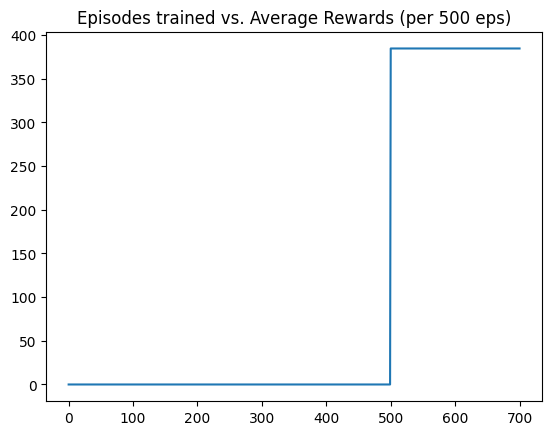

In [9]:
run(training_mode=True, pretrained=False) #300 episodes training 
#ignore plot below! it's not correct but it was too computationally expensive to redo training with a correct plot 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API whic

Total reward after episode 1 is 789.0


 20%|██        | 2/10 [01:14<04:49, 36.13s/it]

Total reward after episode 2 is 758.0


 30%|███       | 3/10 [02:26<06:09, 52.72s/it]

Total reward after episode 3 is 707.0


 40%|████      | 4/10 [02:31<03:23, 33.90s/it]

Total reward after episode 4 is 233.0


 50%|█████     | 5/10 [06:28<08:55, 107.10s/it]

Total reward after episode 5 is 1448.0


 60%|██████    | 6/10 [06:37<04:54, 73.71s/it] 

Total reward after episode 6 is 233.0


 70%|███████   | 7/10 [08:08<03:58, 79.41s/it]

Total reward after episode 7 is 728.0


 80%|████████  | 8/10 [08:13<01:51, 55.77s/it]

Total reward after episode 8 is 237.0


 90%|█████████ | 9/10 [08:31<00:43, 43.88s/it]

Total reward after episode 9 is 623.0


100%|██████████| 10/10 [08:36<00:00, 51.67s/it]

Total reward after episode 10 is 245.0


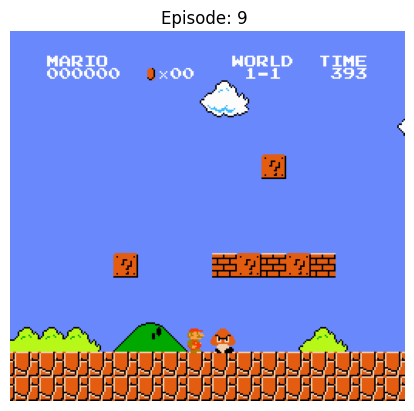

In [13]:
run(training_mode=False, pretrained=True) #300 episodes testing 

In [9]:
run(training_mode=True, pretrained=False) #100 episodes training

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-8-d1f9c5a89b73>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to 

Total reward after episode 1 is 247.0


  2%|▏         | 2/100 [00:22<20:55, 12.81s/it]

Total reward after episode 2 is 639.0


  3%|▎         | 3/100 [00:27<14:42,  9.09s/it]

Total reward after episode 3 is 247.0


  4%|▍         | 4/100 [00:32<11:40,  7.30s/it]

Total reward after episode 4 is 250.0


  5%|▌         | 5/100 [00:35<09:25,  5.95s/it]

Total reward after episode 5 is 250.0


  6%|▌         | 6/100 [00:40<08:35,  5.48s/it]

Total reward after episode 6 is 250.0


  7%|▋         | 7/100 [00:58<14:52,  9.60s/it]

Total reward after episode 7 is 624.0


  8%|▊         | 8/100 [01:01<11:48,  7.70s/it]

Total reward after episode 8 is 248.0


  9%|▉         | 9/100 [01:06<10:12,  6.74s/it]

Total reward after episode 9 is 250.0


 10%|█         | 10/100 [01:10<08:44,  5.83s/it]

Total reward after episode 10 is 248.0


 11%|█         | 11/100 [01:14<07:41,  5.19s/it]

Total reward after episode 11 is 250.0


 12%|█▏        | 12/100 [01:18<07:07,  4.86s/it]

Total reward after episode 12 is 250.0


 13%|█▎        | 13/100 [01:22<06:50,  4.72s/it]

Total reward after episode 13 is 250.0


 14%|█▍        | 14/100 [01:26<06:19,  4.42s/it]

Total reward after episode 14 is 250.0


 15%|█▌        | 15/100 [01:30<06:14,  4.41s/it]

Total reward after episode 15 is 250.0


 16%|█▌        | 16/100 [01:35<06:29,  4.63s/it]

Total reward after episode 16 is 252.0


 17%|█▋        | 17/100 [02:11<19:24, 14.04s/it]

Total reward after episode 17 is 619.0


 18%|█▊        | 18/100 [02:20<16:58, 12.42s/it]

Total reward after episode 18 is 601.0


 19%|█▉        | 19/100 [02:25<13:38, 10.11s/it]

Total reward after episode 19 is 251.0


 20%|██        | 20/100 [02:28<10:52,  8.15s/it]

Total reward after episode 20 is 251.0


 21%|██        | 21/100 [02:32<09:00,  6.85s/it]

Total reward after episode 21 is 251.0


 22%|██▏       | 22/100 [02:36<07:58,  6.13s/it]

Total reward after episode 22 is 251.0


 23%|██▎       | 23/100 [02:40<07:00,  5.46s/it]

Total reward after episode 23 is 251.0


 24%|██▍       | 24/100 [02:44<06:13,  4.92s/it]

Total reward after episode 24 is 251.0


 25%|██▌       | 25/100 [02:48<05:46,  4.63s/it]

Total reward after episode 25 is 251.0


 26%|██▌       | 26/100 [02:52<05:38,  4.58s/it]

Total reward after episode 26 is 251.0


 27%|██▋       | 27/100 [02:56<05:13,  4.30s/it]

Total reward after episode 27 is 251.0


 28%|██▊       | 28/100 [03:00<04:55,  4.10s/it]

Total reward after episode 28 is 251.0


 29%|██▉       | 29/100 [03:05<05:18,  4.48s/it]

Total reward after episode 29 is 245.0


 30%|███       | 30/100 [03:10<05:18,  4.55s/it]

Total reward after episode 30 is 237.0


 31%|███       | 31/100 [03:15<05:26,  4.73s/it]

Total reward after episode 31 is 245.0


 32%|███▏      | 32/100 [03:19<05:14,  4.63s/it]

Total reward after episode 32 is 248.0


 33%|███▎      | 33/100 [03:24<05:09,  4.63s/it]

Total reward after episode 33 is 246.0


 34%|███▍      | 34/100 [03:29<05:14,  4.76s/it]

Total reward after episode 34 is 250.0


 35%|███▌      | 35/100 [03:33<04:49,  4.45s/it]

Total reward after episode 35 is 252.0


 36%|███▌      | 36/100 [03:37<04:47,  4.48s/it]

Total reward after episode 36 is 244.0


 37%|███▋      | 37/100 [03:43<05:08,  4.89s/it]

Total reward after episode 37 is 250.0


 38%|███▊      | 38/100 [03:47<04:43,  4.57s/it]

Total reward after episode 38 is 252.0


 39%|███▉      | 39/100 [03:51<04:20,  4.28s/it]

Total reward after episode 39 is 252.0


 40%|████      | 40/100 [04:26<13:28, 13.47s/it]

Total reward after episode 40 is 795.0


 41%|████      | 41/100 [04:30<10:30, 10.68s/it]

Total reward after episode 41 is 249.0


 42%|████▏     | 42/100 [04:35<08:38,  8.95s/it]

Total reward after episode 42 is 248.0


 43%|████▎     | 43/100 [04:39<07:11,  7.57s/it]

Total reward after episode 43 is 250.0


 44%|████▍     | 44/100 [04:43<05:57,  6.38s/it]

Total reward after episode 44 is 248.0


 45%|████▌     | 45/100 [05:15<13:03, 14.24s/it]

Total reward after episode 45 is 591.0


 46%|████▌     | 46/100 [05:40<15:41, 17.43s/it]

Total reward after episode 46 is 588.0


 47%|████▋     | 47/100 [05:51<13:33, 15.36s/it]

Total reward after episode 47 is 624.0


 48%|████▊     | 48/100 [05:55<10:30, 12.12s/it]

Total reward after episode 48 is 251.0


 49%|████▉     | 49/100 [06:34<17:05, 20.11s/it]

Total reward after episode 49 is 1855.0


 50%|█████     | 50/100 [06:37<12:37, 15.14s/it]

Total reward after episode 50 is 248.0


 51%|█████     | 51/100 [06:41<09:34, 11.72s/it]

Total reward after episode 51 is 251.0


 52%|█████▏    | 52/100 [06:46<07:43,  9.65s/it]

Total reward after episode 52 is 251.0


 53%|█████▎    | 53/100 [07:19<13:00, 16.61s/it]

Total reward after episode 53 is 1031.0


 54%|█████▍    | 54/100 [07:22<09:45, 12.73s/it]

Total reward after episode 54 is 252.0


 55%|█████▌    | 55/100 [07:27<07:43, 10.30s/it]

Total reward after episode 55 is 252.0


 56%|█████▌    | 56/100 [07:31<06:05,  8.30s/it]

Total reward after episode 56 is 248.0


 57%|█████▋    | 57/100 [07:34<04:56,  6.90s/it]

Total reward after episode 57 is 252.0


 58%|█████▊    | 58/100 [07:45<05:42,  8.16s/it]

Total reward after episode 58 is 634.0


 59%|█████▉    | 59/100 [07:49<04:39,  6.81s/it]

Total reward after episode 59 is 252.0


 60%|██████    | 60/100 [07:54<04:07,  6.18s/it]

Total reward after episode 60 is 248.0


 61%|██████    | 61/100 [07:58<03:32,  5.45s/it]

Total reward after episode 61 is 252.0


 62%|██████▏   | 62/100 [08:10<04:41,  7.40s/it]

Total reward after episode 62 is 634.0


 63%|██████▎   | 63/100 [08:13<03:54,  6.32s/it]

Total reward after episode 63 is 251.0


 64%|██████▍   | 64/100 [08:35<06:36, 11.01s/it]

Total reward after episode 64 is 639.0


 65%|██████▌   | 65/100 [08:39<05:08,  8.81s/it]

Total reward after episode 65 is 248.0


 66%|██████▌   | 66/100 [08:44<04:17,  7.56s/it]

Total reward after episode 66 is 252.0


 67%|██████▋   | 67/100 [08:47<03:30,  6.38s/it]

Total reward after episode 67 is 252.0


 68%|██████▊   | 68/100 [09:07<05:33, 10.41s/it]

Total reward after episode 68 is 816.0


 69%|██████▉   | 69/100 [09:11<04:26,  8.60s/it]

Total reward after episode 69 is 247.0


 70%|███████   | 70/100 [09:15<03:33,  7.10s/it]

Total reward after episode 70 is 252.0


 71%|███████   | 71/100 [09:19<02:56,  6.10s/it]

Total reward after episode 71 is 251.0


 72%|███████▏  | 72/100 [09:59<07:35, 16.25s/it]

Total reward after episode 72 is 1023.0


 73%|███████▎  | 73/100 [10:03<05:43, 12.72s/it]

Total reward after episode 73 is 252.0


 74%|███████▍  | 74/100 [10:07<04:20, 10.02s/it]

Total reward after episode 74 is 252.0


 75%|███████▌  | 75/100 [10:11<03:22,  8.09s/it]

Total reward after episode 75 is 252.0


 76%|███████▌  | 76/100 [10:16<02:53,  7.21s/it]

Total reward after episode 76 is 239.0


 77%|███████▋  | 77/100 [10:20<02:24,  6.28s/it]

Total reward after episode 77 is 239.0


 78%|███████▊  | 78/100 [10:41<03:56, 10.77s/it]

Total reward after episode 78 is 815.0


 79%|███████▉  | 79/100 [11:18<06:30, 18.60s/it]

Total reward after episode 79 is 1021.0


 80%|████████  | 80/100 [11:22<04:43, 14.17s/it]

Total reward after episode 80 is 248.0


 81%|████████  | 81/100 [11:25<03:28, 10.99s/it]

Total reward after episode 81 is 252.0


 82%|████████▏ | 82/100 [11:48<04:20, 14.49s/it]

Total reward after episode 82 is 736.0


 83%|████████▎ | 83/100 [11:52<03:11, 11.27s/it]

Total reward after episode 83 is 252.0


 84%|████████▍ | 84/100 [12:20<04:22, 16.39s/it]

Total reward after episode 84 is 743.0


 85%|████████▌ | 85/100 [12:38<04:13, 16.93s/it]

Total reward after episode 85 is 626.0


 86%|████████▌ | 86/100 [12:48<03:26, 14.72s/it]

Total reward after episode 86 is 615.0


 87%|████████▋ | 87/100 [12:52<02:29, 11.49s/it]

Total reward after episode 87 is 252.0


 88%|████████▊ | 88/100 [12:56<01:49,  9.16s/it]

Total reward after episode 88 is 252.0


 89%|████████▉ | 89/100 [13:30<03:03, 16.64s/it]

Total reward after episode 89 is 798.0


 90%|█████████ | 90/100 [13:34<02:08, 12.83s/it]

Total reward after episode 90 is 252.0


 91%|█████████ | 91/100 [13:37<01:30, 10.06s/it]

Total reward after episode 91 is 252.0


 92%|█████████▏| 92/100 [14:02<01:55, 14.41s/it]

Total reward after episode 92 is 1041.0


 93%|█████████▎| 93/100 [14:07<01:21, 11.68s/it]

Total reward after episode 93 is 238.0


 94%|█████████▍| 94/100 [14:18<01:08, 11.42s/it]

Total reward after episode 94 is 608.0


 95%|█████████▌| 95/100 [14:24<00:48,  9.77s/it]

Total reward after episode 95 is 218.0


 96%|█████████▌| 96/100 [14:28<00:31,  8.00s/it]

Total reward after episode 96 is 248.0


 97%|█████████▋| 97/100 [14:47<00:34, 11.48s/it]

Total reward after episode 97 is 611.0


 98%|█████████▊| 98/100 [14:51<00:18,  9.21s/it]

Total reward after episode 98 is 248.0


 99%|█████████▉| 99/100 [14:55<00:07,  7.65s/it]

Total reward after episode 99 is 248.0


100%|██████████| 100/100 [15:00<00:00,  9.00s/it]

Total reward after episode 100 is 252.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API whic

Total reward after episode 1 is 235.0


 20%|██        | 2/10 [00:16<01:09,  8.64s/it]

Total reward after episode 2 is 610.0


 30%|███       | 3/10 [00:32<01:24, 12.07s/it]

Total reward after episode 3 is 632.0


 40%|████      | 4/10 [01:42<03:30, 35.05s/it]

Total reward after episode 4 is 1289.0


 50%|█████     | 5/10 [01:48<02:02, 24.57s/it]

Total reward after episode 5 is 249.0


 60%|██████    | 6/10 [01:54<01:11, 17.99s/it]

Total reward after episode 6 is 248.0


 70%|███████   | 7/10 [01:59<00:41, 13.88s/it]

Total reward after episode 7 is 249.0


 80%|████████  | 8/10 [02:22<00:33, 16.81s/it]

Total reward after episode 8 is 606.0


 90%|█████████ | 9/10 [02:48<00:19, 19.62s/it]

Total reward after episode 9 is 634.0


100%|██████████| 10/10 [03:04<00:00, 18.48s/it]

Total reward after episode 10 is 591.0


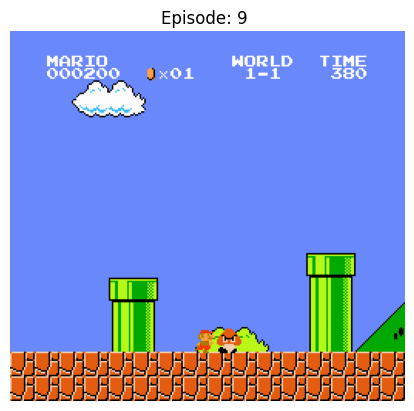

In [13]:
run(training_mode=False, pretrained=True) #100 episodes testing 

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/400 [00:00<?, ?it/s]<ipython-input-8-fa48ec2634f7>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to 

Total reward after episode 1 is 634.0


  0%|          | 2/400 [00:23<1:11:09, 10.73s/it]

Total reward after episode 2 is 237.0


  1%|          | 3/400 [01:00<2:30:23, 22.73s/it]

Total reward after episode 3 is 733.0


  1%|          | 4/400 [01:48<3:33:41, 32.38s/it]

Total reward after episode 4 is 713.0


  1%|▏         | 5/400 [01:54<2:30:13, 22.82s/it]

Total reward after episode 5 is 231.0


  2%|▏         | 6/400 [02:01<1:54:41, 17.47s/it]

Total reward after episode 6 is 231.0


  2%|▏         | 7/400 [02:07<1:29:59, 13.74s/it]

Total reward after episode 7 is 231.0


  2%|▏         | 8/400 [02:14<1:16:07, 11.65s/it]

Total reward after episode 8 is 233.0


  2%|▏         | 9/400 [02:20<1:05:01,  9.98s/it]

Total reward after episode 9 is 231.0


  2%|▎         | 10/400 [02:48<1:40:51, 15.52s/it]

Total reward after episode 10 is 609.0


  3%|▎         | 11/400 [02:54<1:22:13, 12.68s/it]

Total reward after episode 11 is 238.0


  3%|▎         | 12/400 [02:59<1:05:28, 10.12s/it]

Total reward after episode 12 is 252.0


  3%|▎         | 13/400 [03:03<53:51,  8.35s/it]  

Total reward after episode 13 is 252.0


  4%|▎         | 14/400 [03:08<47:50,  7.44s/it]

Total reward after episode 14 is 252.0


  4%|▍         | 15/400 [03:13<41:51,  6.52s/it]

Total reward after episode 15 is 251.0


  4%|▍         | 16/400 [03:17<38:33,  6.03s/it]

Total reward after episode 16 is 251.0


  4%|▍         | 17/400 [03:33<57:24,  8.99s/it]

Total reward after episode 17 is 632.0


  4%|▍         | 18/400 [03:37<47:51,  7.52s/it]

Total reward after episode 18 is 252.0


  5%|▍         | 19/400 [03:43<44:57,  7.08s/it]

Total reward after episode 19 is 250.0


  5%|▌         | 20/400 [03:51<44:58,  7.10s/it]

Total reward after episode 20 is 252.0


  5%|▌         | 21/400 [03:58<44:55,  7.11s/it]

Total reward after episode 21 is 252.0


  6%|▌         | 22/400 [04:18<1:09:59, 11.11s/it]

Total reward after episode 22 is 637.0


  6%|▌         | 23/400 [04:26<1:04:01, 10.19s/it]

Total reward after episode 23 is 252.0


  6%|▌         | 24/400 [04:35<1:01:03,  9.74s/it]

Total reward after episode 24 is 252.0


  6%|▋         | 25/400 [04:42<56:40,  9.07s/it]  

Total reward after episode 25 is 252.0


  6%|▋         | 26/400 [05:03<1:17:13, 12.39s/it]

Total reward after episode 26 is 634.0


  7%|▋         | 27/400 [05:11<1:09:44, 11.22s/it]

Total reward after episode 27 is 251.0


  7%|▋         | 28/400 [05:18<1:01:40,  9.95s/it]

Total reward after episode 28 is 251.0


  7%|▋         | 29/400 [05:25<56:20,  9.11s/it]  

Total reward after episode 29 is 251.0


  8%|▊         | 30/400 [05:32<51:26,  8.34s/it]

Total reward after episode 30 is 252.0


  8%|▊         | 31/400 [06:33<2:29:22, 24.29s/it]

Total reward after episode 31 is 1027.0


  8%|▊         | 32/400 [06:40<1:56:27, 18.99s/it]

Total reward after episode 32 is 251.0


  8%|▊         | 33/400 [07:00<1:58:24, 19.36s/it]

Total reward after episode 33 is 628.0


  8%|▊         | 34/400 [07:07<1:35:19, 15.63s/it]

Total reward after episode 34 is 248.0


  9%|▉         | 35/400 [07:12<1:16:03, 12.50s/it]

Total reward after episode 35 is 249.0


  9%|▉         | 36/400 [07:18<1:04:23, 10.62s/it]

Total reward after episode 36 is 251.0


  9%|▉         | 37/400 [07:24<54:11,  8.96s/it]  

Total reward after episode 37 is 251.0


 10%|▉         | 38/400 [08:01<1:45:48, 17.54s/it]

Total reward after episode 38 is 614.0


 10%|▉         | 39/400 [08:07<1:23:54, 13.95s/it]

Total reward after episode 39 is 248.0


 10%|█         | 40/400 [08:28<1:37:46, 16.30s/it]

Total reward after episode 40 is 628.0


 10%|█         | 41/400 [09:15<2:31:39, 25.35s/it]

Total reward after episode 41 is 1024.0


 10%|█         | 42/400 [09:21<1:57:12, 19.65s/it]

Total reward after episode 42 is 251.0


 11%|█         | 43/400 [09:26<1:30:27, 15.20s/it]

Total reward after episode 43 is 252.0


 11%|█         | 44/400 [09:31<1:11:25, 12.04s/it]

Total reward after episode 44 is 248.0


 11%|█▏        | 45/400 [09:38<1:02:26, 10.55s/it]

Total reward after episode 45 is 248.0


 12%|█▏        | 46/400 [09:54<1:12:51, 12.35s/it]

Total reward after episode 46 is 635.0


 12%|█▏        | 47/400 [10:02<1:03:54, 10.86s/it]

Total reward after episode 47 is 252.0


 12%|█▏        | 48/400 [10:49<2:08:31, 21.91s/it]

Total reward after episode 48 is 609.0


 12%|█▏        | 49/400 [11:07<1:59:59, 20.51s/it]

Total reward after episode 49 is 627.0


 12%|█▎        | 50/400 [11:49<2:38:36, 27.19s/it]

Total reward after episode 50 is 605.0


 13%|█▎        | 51/400 [12:02<2:13:22, 22.93s/it]

Total reward after episode 51 is 628.0


 13%|█▎        | 52/400 [12:16<1:57:28, 20.25s/it]

Total reward after episode 52 is 636.0


 13%|█▎        | 53/400 [12:32<1:48:42, 18.80s/it]

Total reward after episode 53 is 638.0


 14%|█▎        | 54/400 [12:46<1:39:31, 17.26s/it]

Total reward after episode 54 is 635.0


 14%|█▍        | 55/400 [13:02<1:38:16, 17.09s/it]

Total reward after episode 55 is 631.0


 14%|█▍        | 56/400 [13:16<1:31:26, 15.95s/it]

Total reward after episode 56 is 638.0


 14%|█▍        | 57/400 [13:30<1:28:48, 15.54s/it]

Total reward after episode 57 is 635.0


 14%|█▍        | 58/400 [13:44<1:25:26, 14.99s/it]

Total reward after episode 58 is 635.0


 15%|█▍        | 59/400 [13:55<1:19:18, 13.95s/it]

Total reward after episode 59 is 630.0


 15%|█▌        | 60/400 [14:09<1:18:51, 13.92s/it]

Total reward after episode 60 is 630.0


 15%|█▌        | 61/400 [14:23<1:18:56, 13.97s/it]

Total reward after episode 61 is 627.0


 16%|█▌        | 62/400 [14:59<1:55:19, 20.47s/it]

Total reward after episode 62 is 613.0


 16%|█▌        | 63/400 [15:13<1:44:25, 18.59s/it]

Total reward after episode 63 is 629.0


 16%|█▌        | 64/400 [15:20<1:24:19, 15.06s/it]

Total reward after episode 64 is 252.0


 16%|█▋        | 65/400 [15:34<1:23:12, 14.90s/it]

Total reward after episode 65 is 625.0


 16%|█▋        | 66/400 [15:50<1:24:15, 15.14s/it]

Total reward after episode 66 is 633.0


 17%|█▋        | 67/400 [16:07<1:27:29, 15.76s/it]

Total reward after episode 67 is 630.0


 17%|█▋        | 68/400 [16:14<1:12:26, 13.09s/it]

Total reward after episode 68 is 237.0


 17%|█▋        | 69/400 [16:45<1:40:46, 18.27s/it]

Total reward after episode 69 is 592.0


 18%|█▊        | 70/400 [16:50<1:18:46, 14.32s/it]

Total reward after episode 70 is 252.0


 18%|█▊        | 71/400 [17:16<1:38:27, 17.96s/it]

Total reward after episode 71 is 634.0


 18%|█▊        | 72/400 [17:32<1:35:26, 17.46s/it]

Total reward after episode 72 is 624.0


 18%|█▊        | 73/400 [17:47<1:30:59, 16.70s/it]

Total reward after episode 73 is 627.0


 18%|█▊        | 74/400 [18:22<1:59:12, 21.94s/it]

Total reward after episode 74 is 1347.0


 19%|█▉        | 75/400 [19:05<2:34:36, 28.54s/it]

Total reward after episode 75 is 620.0


 19%|█▉        | 76/400 [19:37<2:38:41, 29.39s/it]

Total reward after episode 76 is 632.0


 19%|█▉        | 77/400 [20:12<2:48:00, 31.21s/it]

Total reward after episode 77 is 633.0


 20%|█▉        | 78/400 [20:48<2:55:21, 32.67s/it]

Total reward after episode 78 is 626.0


 20%|█▉        | 79/400 [21:25<3:01:42, 33.96s/it]

Total reward after episode 79 is 627.0


 20%|██        | 80/400 [22:03<3:06:43, 35.01s/it]

Total reward after episode 80 is 635.0


 20%|██        | 81/400 [22:40<3:09:37, 35.66s/it]

Total reward after episode 81 is 625.0


 20%|██        | 82/400 [23:08<2:56:38, 33.33s/it]

Total reward after episode 82 is 624.0


 21%|██        | 83/400 [24:30<4:14:09, 48.11s/it]

Total reward after episode 83 is 1034.0


 21%|██        | 84/400 [25:21<4:17:30, 48.89s/it]

Total reward after episode 84 is 816.0


 21%|██▏       | 85/400 [25:29<3:12:24, 36.65s/it]

Total reward after episode 85 is 239.0


 22%|██▏       | 86/400 [25:46<2:40:38, 30.70s/it]

Total reward after episode 86 is 626.0


 22%|██▏       | 87/400 [26:04<2:20:49, 26.99s/it]

Total reward after episode 87 is 623.0


 22%|██▏       | 88/400 [26:19<2:01:45, 23.42s/it]

Total reward after episode 88 is 628.0


 22%|██▏       | 89/400 [26:34<1:47:52, 20.81s/it]

Total reward after episode 89 is 625.0


 22%|██▎       | 90/400 [27:05<2:02:23, 23.69s/it]

Total reward after episode 90 is 1348.0


 23%|██▎       | 91/400 [27:10<1:33:29, 18.16s/it]

Total reward after episode 91 is 250.0


 23%|██▎       | 92/400 [28:02<2:25:32, 28.35s/it]

Total reward after episode 92 is 1006.0


 23%|██▎       | 93/400 [28:57<3:05:51, 36.32s/it]

Total reward after episode 93 is 1852.0


 24%|██▎       | 94/400 [29:11<2:31:25, 29.69s/it]

Total reward after episode 94 is 633.0


 24%|██▍       | 95/400 [29:19<1:57:53, 23.19s/it]

Total reward after episode 95 is 248.0


 24%|██▍       | 96/400 [29:41<1:55:03, 22.71s/it]

Total reward after episode 96 is 623.0


 24%|██▍       | 97/400 [30:28<2:31:28, 30.00s/it]

Total reward after episode 97 is 1342.0


 24%|██▍       | 98/400 [30:36<1:58:48, 23.60s/it]

Total reward after episode 98 is 247.0


 25%|██▍       | 99/400 [30:46<1:37:38, 19.46s/it]

Total reward after episode 99 is 236.0


 25%|██▌       | 100/400 [31:28<2:11:11, 26.24s/it]

Total reward after episode 100 is 1343.0


 25%|██▌       | 101/400 [31:45<1:56:25, 23.36s/it]

Total reward after episode 101 is 626.0


 26%|██▌       | 102/400 [32:18<2:10:27, 26.27s/it]

Total reward after episode 102 is 1349.0


 26%|██▌       | 103/400 [32:51<2:20:39, 28.42s/it]

Total reward after episode 103 is 1044.0


 26%|██▌       | 104/400 [32:57<1:45:45, 21.44s/it]

Total reward after episode 104 is 252.0


 26%|██▋       | 105/400 [33:35<2:09:55, 26.43s/it]

Total reward after episode 105 is 1341.0


 26%|██▋       | 106/400 [34:05<2:14:37, 27.47s/it]

Total reward after episode 106 is 816.0


 27%|██▋       | 107/400 [34:45<2:33:15, 31.38s/it]

Total reward after episode 107 is 1337.0


 27%|██▋       | 108/400 [35:15<2:30:21, 30.89s/it]

Total reward after episode 108 is 622.0


 27%|██▋       | 109/400 [35:48<2:33:35, 31.67s/it]

Total reward after episode 109 is 1346.0


 28%|██▊       | 110/400 [36:07<2:13:40, 27.66s/it]

Total reward after episode 110 is 629.0


 28%|██▊       | 111/400 [36:12<1:40:27, 20.86s/it]

Total reward after episode 111 is 251.0


 28%|██▊       | 112/400 [36:29<1:35:25, 19.88s/it]

Total reward after episode 112 is 629.0


 28%|██▊       | 113/400 [36:55<1:43:28, 21.63s/it]

Total reward after episode 113 is 814.0


 28%|██▊       | 114/400 [37:10<1:33:34, 19.63s/it]

Total reward after episode 114 is 624.0


 29%|██▉       | 115/400 [37:14<1:11:37, 15.08s/it]

Total reward after episode 115 is 242.0


 29%|██▉       | 116/400 [37:37<1:21:44, 17.27s/it]

Total reward after episode 116 is 817.0


 29%|██▉       | 117/400 [37:42<1:04:37, 13.70s/it]

Total reward after episode 117 is 240.0


 30%|██▉       | 118/400 [38:07<1:20:31, 17.13s/it]

Total reward after episode 118 is 1351.0


 30%|██▉       | 119/400 [38:25<1:21:03, 17.31s/it]

Total reward after episode 119 is 618.0


 30%|███       | 120/400 [38:38<1:15:00, 16.07s/it]

Total reward after episode 120 is 637.0


 30%|███       | 121/400 [38:43<59:10, 12.72s/it]  

Total reward after episode 121 is 252.0


 30%|███       | 122/400 [38:58<1:01:56, 13.37s/it]

Total reward after episode 122 is 625.0


 31%|███       | 123/400 [39:12<1:03:18, 13.71s/it]

Total reward after episode 123 is 618.0


 31%|███       | 124/400 [39:26<1:02:14, 13.53s/it]

Total reward after episode 124 is 620.0


 31%|███▏      | 125/400 [39:51<1:18:01, 17.02s/it]

Total reward after episode 125 is 1042.0


 32%|███▏      | 126/400 [40:23<1:38:48, 21.64s/it]

Total reward after episode 126 is 1340.0


 32%|███▏      | 127/400 [40:49<1:44:13, 22.90s/it]

Total reward after episode 127 is 781.0


 32%|███▏      | 128/400 [40:54<1:19:06, 17.45s/it]

Total reward after episode 128 is 248.0


 32%|███▏      | 129/400 [41:32<1:47:30, 23.80s/it]

Total reward after episode 129 is 1336.0


 32%|███▎      | 130/400 [41:46<1:33:06, 20.69s/it]

Total reward after episode 130 is 612.0


 33%|███▎      | 131/400 [42:00<1:24:11, 18.78s/it]

Total reward after episode 131 is 622.0


 33%|███▎      | 132/400 [42:31<1:39:36, 22.30s/it]

Total reward after episode 132 is 1339.0


 33%|███▎      | 133/400 [43:30<2:29:08, 33.51s/it]

Total reward after episode 133 is 1305.0


 34%|███▎      | 134/400 [43:51<2:11:29, 29.66s/it]

Total reward after episode 134 is 641.0


 34%|███▍      | 135/400 [43:57<1:39:11, 22.46s/it]

Total reward after episode 135 is 251.0


 34%|███▍      | 136/400 [44:09<1:24:53, 19.30s/it]

Total reward after episode 136 is 631.0


 34%|███▍      | 137/400 [44:33<1:31:54, 20.97s/it]

Total reward after episode 137 is 750.0


 34%|███▍      | 138/400 [44:48<1:23:16, 19.07s/it]

Total reward after episode 138 is 619.0


 35%|███▍      | 139/400 [45:28<1:50:11, 25.33s/it]

Total reward after episode 139 is 1326.0


 35%|███▌      | 140/400 [45:41<1:33:42, 21.63s/it]

Total reward after episode 140 is 620.0


 35%|███▌      | 141/400 [46:09<1:41:26, 23.50s/it]

Total reward after episode 141 is 1039.0


 36%|███▌      | 142/400 [46:26<1:32:51, 21.60s/it]

Total reward after episode 142 is 738.0


 36%|███▌      | 143/400 [46:31<1:11:06, 16.60s/it]

Total reward after episode 143 is 249.0


 36%|███▌      | 144/400 [46:35<55:03, 12.90s/it]  

Total reward after episode 144 is 248.0


 36%|███▋      | 145/400 [46:56<1:05:05, 15.31s/it]

Total reward after episode 145 is 641.0


 36%|███▋      | 146/400 [47:42<1:44:06, 24.59s/it]

Total reward after episode 146 is 1559.0


 37%|███▋      | 147/400 [48:06<1:42:58, 24.42s/it]

Total reward after episode 147 is 1438.0


 37%|███▋      | 148/400 [48:20<1:28:19, 21.03s/it]

Total reward after episode 148 is 625.0


 37%|███▋      | 149/400 [48:23<1:06:33, 15.91s/it]

Total reward after episode 149 is 249.0


 38%|███▊      | 150/400 [48:53<1:23:10, 19.96s/it]

Total reward after episode 150 is 1341.0


 38%|███▊      | 151/400 [49:38<1:54:29, 27.59s/it]

Total reward after episode 151 is 1323.0


 38%|███▊      | 152/400 [50:01<1:47:27, 26.00s/it]

Total reward after episode 152 is 604.0


 38%|███▊      | 153/400 [50:33<1:55:21, 28.02s/it]

Total reward after episode 153 is 1342.0


 38%|███▊      | 154/400 [51:02<1:55:40, 28.21s/it]

Total reward after episode 154 is 1342.0


 39%|███▉      | 155/400 [51:07<1:26:47, 21.26s/it]

Total reward after episode 155 is 252.0


 39%|███▉      | 156/400 [51:49<1:51:24, 27.39s/it]

Total reward after episode 156 is 1021.0


 39%|███▉      | 157/400 [52:29<2:06:28, 31.23s/it]

Total reward after episode 157 is 1333.0


 40%|███▉      | 158/400 [52:34<1:33:50, 23.27s/it]

Total reward after episode 158 is 235.0


 40%|███▉      | 159/400 [53:06<1:44:28, 26.01s/it]

Total reward after episode 159 is 1340.0


 40%|████      | 160/400 [53:43<1:57:26, 29.36s/it]

Total reward after episode 160 is 1333.0


 40%|████      | 161/400 [54:13<1:57:53, 29.60s/it]

Total reward after episode 161 is 1341.0


 40%|████      | 162/400 [54:35<1:47:28, 27.09s/it]

Total reward after episode 162 is 603.0


 41%|████      | 163/400 [55:08<1:54:57, 29.10s/it]

Total reward after episode 163 is 1339.0


 41%|████      | 164/400 [55:22<1:36:48, 24.61s/it]

Total reward after episode 164 is 617.0


 41%|████▏     | 165/400 [55:36<1:23:51, 21.41s/it]

Total reward after episode 165 is 623.0


 42%|████▏     | 166/400 [56:14<1:42:41, 26.33s/it]

Total reward after episode 166 is 578.0


 42%|████▏     | 167/400 [56:55<1:59:02, 30.66s/it]

Total reward after episode 167 is 1328.0


 42%|████▏     | 168/400 [57:21<1:53:05, 29.25s/it]

Total reward after episode 168 is 1041.0


 42%|████▏     | 169/400 [57:57<2:00:14, 31.23s/it]

Total reward after episode 169 is 1566.0


 42%|████▎     | 170/400 [58:25<1:56:18, 30.34s/it]

Total reward after episode 170 is 1433.0


 43%|████▎     | 171/400 [58:51<1:50:45, 29.02s/it]

Total reward after episode 171 is 1062.0


 43%|████▎     | 172/400 [59:14<1:43:55, 27.35s/it]

Total reward after episode 172 is 1045.0


 43%|████▎     | 173/400 [59:40<1:41:43, 26.89s/it]

Total reward after episode 173 is 1349.0


 44%|████▎     | 174/400 [59:45<1:15:52, 20.14s/it]

Total reward after episode 174 is 235.0


 44%|████▍     | 175/400 [1:00:06<1:16:42, 20.45s/it]

Total reward after episode 175 is 1043.0


 44%|████▍     | 176/400 [1:00:26<1:15:38, 20.26s/it]

Total reward after episode 176 is 816.0


 44%|████▍     | 177/400 [1:00:49<1:19:05, 21.28s/it]

Total reward after episode 177 is 813.0


 44%|████▍     | 178/400 [1:01:12<1:20:17, 21.70s/it]

Total reward after episode 178 is 1046.0


 45%|████▍     | 179/400 [1:01:16<1:00:14, 16.36s/it]

Total reward after episode 179 is 247.0


 45%|████▌     | 180/400 [1:01:29<56:31, 15.42s/it]  

Total reward after episode 180 is 606.0


 45%|████▌     | 181/400 [1:01:52<1:04:43, 17.73s/it]

Total reward after episode 181 is 813.0


 46%|████▌     | 182/400 [1:02:04<57:37, 15.86s/it]  

Total reward after episode 182 is 625.0


 46%|████▌     | 183/400 [1:02:33<1:11:21, 19.73s/it]

Total reward after episode 183 is 1341.0


 46%|████▌     | 184/400 [1:03:03<1:22:33, 22.93s/it]

Total reward after episode 184 is 1338.0


 46%|████▋     | 185/400 [1:03:45<1:42:16, 28.54s/it]

Total reward after episode 185 is 1558.0


 46%|████▋     | 186/400 [1:04:08<1:36:16, 26.99s/it]

Total reward after episode 186 is 781.0


 47%|████▋     | 187/400 [1:04:35<1:35:29, 26.90s/it]

Total reward after episode 187 is 1039.0


 47%|████▋     | 188/400 [1:04:56<1:29:33, 25.35s/it]

Total reward after episode 188 is 640.0


 47%|████▋     | 189/400 [1:05:20<1:27:38, 24.92s/it]

Total reward after episode 189 is 1042.0


 48%|████▊     | 190/400 [1:05:38<1:19:39, 22.76s/it]

Total reward after episode 190 is 739.0


 48%|████▊     | 191/400 [1:06:06<1:24:53, 24.37s/it]

Total reward after episode 191 is 1035.0


 48%|████▊     | 192/400 [1:06:27<1:21:05, 23.39s/it]

Total reward after episode 192 is 738.0


 48%|████▊     | 193/400 [1:06:46<1:15:58, 22.02s/it]

Total reward after episode 193 is 599.0


 48%|████▊     | 194/400 [1:07:08<1:15:58, 22.13s/it]

Total reward after episode 194 is 1347.0


 49%|████▉     | 195/400 [1:07:12<56:46, 16.62s/it]  

Total reward after episode 195 is 252.0


 49%|████▉     | 196/400 [1:07:22<49:54, 14.68s/it]

Total reward after episode 196 is 610.0


 49%|████▉     | 197/400 [1:07:26<38:33, 11.40s/it]

Total reward after episode 197 is 252.0


 50%|████▉     | 198/400 [1:07:48<48:58, 14.55s/it]

Total reward after episode 198 is 608.0


 50%|████▉     | 199/400 [1:08:07<53:01, 15.83s/it]

Total reward after episode 199 is 1047.0


 50%|█████     | 200/400 [1:08:27<57:34, 17.27s/it]

Total reward after episode 200 is 817.0


 50%|█████     | 201/400 [1:08:54<1:06:08, 19.94s/it]

Total reward after episode 201 is 1038.0


 50%|█████     | 202/400 [1:09:07<59:17, 17.97s/it]  

Total reward after episode 202 is 613.0


 51%|█████     | 203/400 [1:10:18<1:51:30, 33.96s/it]

Total reward after episode 203 is 979.0


 51%|█████     | 204/400 [1:11:03<2:01:48, 37.29s/it]

Total reward after episode 204 is 1036.0


 51%|█████▏    | 205/400 [1:11:50<2:10:02, 40.01s/it]

Total reward after episode 205 is 743.0


 52%|█████▏    | 206/400 [1:12:17<1:57:08, 36.23s/it]

Total reward after episode 206 is 760.0


 52%|█████▏    | 207/400 [1:13:07<2:09:31, 40.27s/it]

Total reward after episode 207 is 1317.0


 52%|█████▏    | 208/400 [1:13:47<2:08:28, 40.15s/it]

Total reward after episode 208 is 584.0


 52%|█████▏    | 209/400 [1:13:57<1:39:28, 31.25s/it]

Total reward after episode 209 is 615.0


 52%|█████▎    | 210/400 [1:14:09<1:20:29, 25.42s/it]

Total reward after episode 210 is 617.0


 53%|█████▎    | 211/400 [1:14:21<1:07:47, 21.52s/it]

Total reward after episode 211 is 617.0


 53%|█████▎    | 212/400 [1:14:30<55:27, 17.70s/it]  

Total reward after episode 212 is 607.0


 53%|█████▎    | 213/400 [1:15:07<1:13:07, 23.46s/it]

Total reward after episode 213 is 1328.0


 54%|█████▎    | 214/400 [1:15:39<1:20:42, 26.03s/it]

Total reward after episode 214 is 1034.0


 54%|█████▍    | 215/400 [1:16:25<1:38:34, 31.97s/it]

Total reward after episode 215 is 783.0


 54%|█████▍    | 216/400 [1:16:34<1:17:13, 25.18s/it]

Total reward after episode 216 is 611.0


 54%|█████▍    | 217/400 [1:17:16<1:32:01, 30.17s/it]

Total reward after episode 217 is 789.0


 55%|█████▍    | 218/400 [1:17:42<1:27:45, 28.93s/it]

Total reward after episode 218 is 809.0


 55%|█████▍    | 219/400 [1:18:35<1:49:17, 36.23s/it]

Total reward after episode 219 is 1004.0


 55%|█████▌    | 220/400 [1:19:02<1:39:42, 33.24s/it]

Total reward after episode 220 is 1038.0


 55%|█████▌    | 221/400 [1:19:23<1:28:59, 29.83s/it]

Total reward after episode 221 is 777.0


 56%|█████▌    | 222/400 [1:19:53<1:28:03, 29.68s/it]

Total reward after episode 222 is 1035.0


 56%|█████▌    | 223/400 [1:19:57<1:04:57, 22.02s/it]

Total reward after episode 223 is 245.0


 56%|█████▌    | 224/400 [1:20:22<1:07:09, 22.89s/it]

Total reward after episode 224 is 1042.0


 56%|█████▋    | 225/400 [1:20:32<55:36, 19.07s/it]  

Total reward after episode 225 is 610.0


 56%|█████▋    | 226/400 [1:20:58<1:00:55, 21.01s/it]

Total reward after episode 226 is 1576.0


 57%|█████▋    | 227/400 [1:21:26<1:06:51, 23.19s/it]

Total reward after episode 227 is 1038.0


 57%|█████▋    | 228/400 [1:21:53<1:09:50, 24.36s/it]

Total reward after episode 228 is 1341.0


 57%|█████▋    | 229/400 [1:22:17<1:09:17, 24.31s/it]

Total reward after episode 229 is 1349.0


 57%|█████▊    | 230/400 [1:22:21<51:28, 18.16s/it]  

Total reward after episode 230 is 248.0


 58%|█████▊    | 231/400 [1:22:26<40:29, 14.37s/it]

Total reward after episode 231 is 235.0


 58%|█████▊    | 232/400 [1:22:47<45:18, 16.18s/it]

Total reward after episode 232 is 1045.0


 58%|█████▊    | 233/400 [1:22:59<41:33, 14.93s/it]

Total reward after episode 233 is 604.0


 58%|█████▊    | 234/400 [1:23:35<58:30, 21.15s/it]

Total reward after episode 234 is 800.0


 59%|█████▉    | 235/400 [1:23:46<50:14, 18.27s/it]

Total reward after episode 235 is 611.0


 59%|█████▉    | 236/400 [1:24:11<54:58, 20.11s/it]

Total reward after episode 236 is 814.0


 59%|█████▉    | 237/400 [1:24:21<46:27, 17.10s/it]

Total reward after episode 237 is 610.0


 60%|█████▉    | 238/400 [1:25:16<1:17:08, 28.57s/it]

Total reward after episode 238 is 1307.0


 60%|█████▉    | 239/400 [1:26:15<1:40:51, 37.59s/it]

Total reward after episode 239 is 1307.0


 60%|██████    | 240/400 [1:26:40<1:30:13, 33.83s/it]

Total reward after episode 240 is 751.0


 60%|██████    | 241/400 [1:26:54<1:14:19, 28.05s/it]

Total reward after episode 241 is 621.0


 60%|██████    | 242/400 [1:27:28<1:18:24, 29.78s/it]

Total reward after episode 242 is 1336.0


 61%|██████    | 243/400 [1:28:02<1:20:53, 30.91s/it]

Total reward after episode 243 is 1335.0


 61%|██████    | 244/400 [1:28:43<1:28:34, 34.07s/it]

Total reward after episode 244 is 1023.0


 61%|██████▏   | 245/400 [1:28:52<1:08:43, 26.60s/it]

Total reward after episode 245 is 610.0


 62%|██████▏   | 246/400 [1:29:31<1:17:32, 30.21s/it]

Total reward after episode 246 is 795.0


 62%|██████▏   | 247/400 [1:29:52<1:10:05, 27.49s/it]

Total reward after episode 247 is 817.0


 62%|██████▏   | 248/400 [1:30:01<56:00, 22.11s/it]  

Total reward after episode 248 is 609.0


 62%|██████▏   | 249/400 [1:30:11<46:07, 18.33s/it]

Total reward after episode 249 is 606.0


 62%|██████▎   | 250/400 [1:30:35<50:11, 20.08s/it]

Total reward after episode 250 is 1065.0


 63%|██████▎   | 251/400 [1:30:40<38:22, 15.45s/it]

Total reward after episode 251 is 248.0


 63%|██████▎   | 252/400 [1:30:44<29:43, 12.05s/it]

Total reward after episode 252 is 252.0


 63%|██████▎   | 253/400 [1:30:56<29:34, 12.07s/it]

Total reward after episode 253 is 608.0


 64%|██████▎   | 254/400 [1:31:00<23:28,  9.65s/it]

Total reward after episode 254 is 248.0


 64%|██████▍   | 255/400 [1:31:10<23:19,  9.65s/it]

Total reward after episode 255 is 616.0


 64%|██████▍   | 256/400 [1:31:33<32:44, 13.64s/it]

Total reward after episode 256 is 814.0


 64%|██████▍   | 257/400 [1:31:49<34:37, 14.53s/it]

Total reward after episode 257 is 741.0


 64%|██████▍   | 258/400 [1:32:38<58:21, 24.66s/it]

Total reward after episode 258 is 1012.0


 65%|██████▍   | 259/400 [1:32:47<47:01, 20.01s/it]

Total reward after episode 259 is 610.0


 65%|██████▌   | 260/400 [1:33:00<42:07, 18.05s/it]

Total reward after episode 260 is 613.0


 65%|██████▌   | 261/400 [1:33:22<44:38, 19.27s/it]

Total reward after episode 261 is 816.0


 66%|██████▌   | 262/400 [1:33:31<37:18, 16.22s/it]

Total reward after episode 262 is 606.0


 66%|██████▌   | 263/400 [1:33:45<34:56, 15.30s/it]

Total reward after episode 263 is 603.0


 66%|██████▌   | 264/400 [1:34:11<42:21, 18.69s/it]

Total reward after episode 264 is 810.0


 66%|██████▋   | 265/400 [1:34:32<43:23, 19.28s/it]

Total reward after episode 265 is 1048.0


 66%|██████▋   | 266/400 [1:34:42<37:10, 16.64s/it]

Total reward after episode 266 is 630.0


 67%|██████▋   | 267/400 [1:34:51<31:21, 14.15s/it]

Total reward after episode 267 is 609.0


 67%|██████▋   | 268/400 [1:35:01<28:22, 12.89s/it]

Total reward after episode 268 is 610.0


 67%|██████▋   | 269/400 [1:35:39<44:34, 20.41s/it]

Total reward after episode 269 is 1329.0


 68%|██████▊   | 270/400 [1:36:08<50:18, 23.22s/it]

Total reward after episode 270 is 1033.0


 68%|██████▊   | 271/400 [1:36:20<42:24, 19.73s/it]

Total reward after episode 271 is 634.0


 68%|██████▊   | 272/400 [1:36:29<35:23, 16.59s/it]

Total reward after episode 272 is 614.0


 68%|██████▊   | 273/400 [1:36:39<30:51, 14.58s/it]

Total reward after episode 273 is 606.0


 68%|██████▊   | 274/400 [1:36:44<24:29, 11.67s/it]

Total reward after episode 274 is 248.0


 69%|██████▉   | 275/400 [1:36:57<25:11, 12.09s/it]

Total reward after episode 275 is 606.0


 69%|██████▉   | 276/400 [1:37:08<23:59, 11.61s/it]

Total reward after episode 276 is 631.0


 69%|██████▉   | 277/400 [1:37:20<24:30, 11.96s/it]

Total reward after episode 277 is 624.0


 70%|██████▉   | 278/400 [1:37:32<24:19, 11.96s/it]

Total reward after episode 278 is 631.0


 70%|██████▉   | 279/400 [1:37:52<28:38, 14.21s/it]

Total reward after episode 279 is 818.0


 70%|███████   | 280/400 [1:37:57<22:49, 11.41s/it]

Total reward after episode 280 is 250.0


 70%|███████   | 281/400 [1:38:18<28:46, 14.51s/it]

Total reward after episode 281 is 780.0


 70%|███████   | 282/400 [1:38:52<39:33, 20.11s/it]

Total reward after episode 282 is 1575.0


 71%|███████   | 283/400 [1:39:04<34:42, 17.80s/it]

Total reward after episode 283 is 625.0


 71%|███████   | 284/400 [1:39:17<31:36, 16.34s/it]

Total reward after episode 284 is 631.0


 71%|███████▏  | 285/400 [1:39:28<28:12, 14.71s/it]

Total reward after episode 285 is 615.0


 72%|███████▏  | 286/400 [1:39:41<26:56, 14.18s/it]

Total reward after episode 286 is 605.0


 72%|███████▏  | 287/400 [1:40:42<53:10, 28.23s/it]

Total reward after episode 287 is 1300.0


 72%|███████▏  | 288/400 [1:40:52<42:48, 22.93s/it]

Total reward after episode 288 is 615.0


 72%|███████▏  | 289/400 [1:41:05<36:33, 19.76s/it]

Total reward after episode 289 is 622.0


 72%|███████▎  | 290/400 [1:41:19<33:19, 18.17s/it]

Total reward after episode 290 is 636.0


 73%|███████▎  | 291/400 [1:41:28<27:53, 15.36s/it]

Total reward after episode 291 is 610.0


 73%|███████▎  | 292/400 [1:41:39<25:23, 14.11s/it]

Total reward after episode 292 is 607.0


 73%|███████▎  | 293/400 [1:41:45<20:34, 11.54s/it]

Total reward after episode 293 is 237.0


 74%|███████▎  | 294/400 [1:41:49<16:33,  9.37s/it]

Total reward after episode 294 is 250.0


 74%|███████▍  | 295/400 [1:42:13<24:02, 13.74s/it]

Total reward after episode 295 is 1329.0


 74%|███████▍  | 296/400 [1:42:35<27:55, 16.11s/it]

Total reward after episode 296 is 817.0


 74%|███████▍  | 297/400 [1:42:47<25:44, 14.99s/it]

Total reward after episode 297 is 633.0


 74%|███████▍  | 298/400 [1:43:12<30:27, 17.92s/it]

Total reward after episode 298 is 742.0


 75%|███████▍  | 299/400 [1:43:53<41:52, 24.88s/it]

Total reward after episode 299 is 788.0


 75%|███████▌  | 300/400 [1:44:02<33:44, 20.25s/it]

Total reward after episode 300 is 606.0


 75%|███████▌  | 301/400 [1:44:06<25:28, 15.43s/it]

Total reward after episode 301 is 242.0


 76%|███████▌  | 302/400 [1:44:33<30:50, 18.88s/it]

Total reward after episode 302 is 1344.0


 76%|███████▌  | 303/400 [1:44:42<25:42, 15.91s/it]

Total reward after episode 303 is 609.0


 76%|███████▌  | 304/400 [1:45:12<31:51, 19.91s/it]

Total reward after episode 304 is 807.0


 76%|███████▋  | 305/400 [1:45:20<26:12, 16.56s/it]

Total reward after episode 305 is 610.0


 76%|███████▋  | 306/400 [1:45:29<22:18, 14.23s/it]

Total reward after episode 306 is 608.0


 77%|███████▋  | 307/400 [1:45:53<26:33, 17.13s/it]

Total reward after episode 307 is 1041.0


 77%|███████▋  | 308/400 [1:46:05<23:53, 15.59s/it]

Total reward after episode 308 is 628.0


 77%|███████▋  | 309/400 [1:46:16<21:40, 14.29s/it]

Total reward after episode 309 is 638.0


 78%|███████▊  | 310/400 [1:46:28<20:09, 13.44s/it]

Total reward after episode 310 is 635.0


 78%|███████▊  | 311/400 [1:46:50<23:58, 16.16s/it]

Total reward after episode 311 is 778.0


 78%|███████▊  | 312/400 [1:47:03<21:59, 15.00s/it]

Total reward after episode 312 is 623.0


 78%|███████▊  | 313/400 [1:47:12<19:20, 13.34s/it]

Total reward after episode 313 is 614.0


 78%|███████▊  | 314/400 [1:47:21<17:05, 11.92s/it]

Total reward after episode 314 is 611.0


 79%|███████▉  | 315/400 [1:47:25<13:45,  9.71s/it]

Total reward after episode 315 is 252.0


 79%|███████▉  | 316/400 [1:47:29<11:10,  7.98s/it]

Total reward after episode 316 is 248.0


 79%|███████▉  | 317/400 [1:47:40<12:25,  8.98s/it]

Total reward after episode 317 is 639.0


 80%|███████▉  | 318/400 [1:47:57<15:34, 11.39s/it]

Total reward after episode 318 is 741.0


 80%|███████▉  | 319/400 [1:48:06<14:22, 10.65s/it]

Total reward after episode 319 is 610.0


 80%|████████  | 320/400 [1:48:12<12:04,  9.05s/it]

Total reward after episode 320 is 239.0


 80%|████████  | 321/400 [1:48:23<12:52,  9.78s/it]

Total reward after episode 321 is 634.0


 80%|████████  | 322/400 [1:48:54<20:46, 15.99s/it]

Total reward after episode 322 is 1428.0


 81%|████████  | 323/400 [1:49:37<30:59, 24.15s/it]

Total reward after episode 323 is 1835.0


 81%|████████  | 324/400 [1:49:51<26:43, 21.10s/it]

Total reward after episode 324 is 610.0


 81%|████████▏ | 325/400 [1:49:55<20:01, 16.02s/it]

Total reward after episode 325 is 242.0


 82%|████████▏ | 326/400 [1:50:05<17:32, 14.22s/it]

Total reward after episode 326 is 610.0


 82%|████████▏ | 327/400 [1:50:14<15:18, 12.58s/it]

Total reward after episode 327 is 610.0


 82%|████████▏ | 328/400 [1:50:51<23:59, 20.00s/it]

Total reward after episode 328 is 793.0


 82%|████████▏ | 329/400 [1:51:00<19:52, 16.80s/it]

Total reward after episode 329 is 606.0


 82%|████████▎ | 330/400 [1:51:35<26:00, 22.29s/it]

Total reward after episode 330 is 580.0


 83%|████████▎ | 331/400 [1:51:39<19:19, 16.81s/it]

Total reward after episode 331 is 249.0


 83%|████████▎ | 332/400 [1:51:44<14:54, 13.16s/it]

Total reward after episode 332 is 240.0


 83%|████████▎ | 333/400 [1:52:17<21:25, 19.19s/it]

Total reward after episode 333 is 1335.0


 84%|████████▎ | 334/400 [1:52:27<17:53, 16.27s/it]

Total reward after episode 334 is 611.0


 84%|████████▍ | 335/400 [1:52:55<21:27, 19.80s/it]

Total reward after episode 335 is 1331.0


 84%|████████▍ | 336/400 [1:53:00<16:16, 15.26s/it]

Total reward after episode 336 is 247.0


 84%|████████▍ | 337/400 [1:53:09<14:04, 13.41s/it]

Total reward after episode 337 is 613.0


 84%|████████▍ | 338/400 [1:53:13<11:11, 10.82s/it]

Total reward after episode 338 is 252.0


 85%|████████▍ | 339/400 [1:53:22<10:20, 10.18s/it]

Total reward after episode 339 is 606.0


 85%|████████▌ | 340/400 [1:53:28<08:46,  8.77s/it]

Total reward after episode 340 is 235.0


 85%|████████▌ | 341/400 [1:53:46<11:27, 11.65s/it]

Total reward after episode 341 is 1164.0


 86%|████████▌ | 342/400 [1:53:56<10:51, 11.24s/it]

Total reward after episode 342 is 608.0


 86%|████████▌ | 343/400 [1:54:06<10:14, 10.78s/it]

Total reward after episode 343 is 612.0


 86%|████████▌ | 344/400 [1:54:44<17:37, 18.88s/it]

Total reward after episode 344 is 1310.0


 86%|████████▋ | 345/400 [1:54:49<13:26, 14.67s/it]

Total reward after episode 345 is 242.0


 86%|████████▋ | 346/400 [1:55:17<16:55, 18.81s/it]

Total reward after episode 346 is 1035.0


 87%|████████▋ | 347/400 [1:55:27<14:14, 16.13s/it]

Total reward after episode 347 is 612.0


 87%|████████▋ | 348/400 [1:55:36<12:12, 14.09s/it]

Total reward after episode 348 is 609.0


 87%|████████▋ | 349/400 [1:55:58<13:53, 16.34s/it]

Total reward after episode 349 is 815.0


 88%|████████▊ | 350/400 [1:56:03<10:43, 12.86s/it]

Total reward after episode 350 is 250.0


 88%|████████▊ | 351/400 [1:56:25<12:43, 15.59s/it]

Total reward after episode 351 is 1047.0


 88%|████████▊ | 352/400 [1:56:56<16:12, 20.25s/it]

Total reward after episode 352 is 1034.0


 88%|████████▊ | 353/400 [1:57:15<15:38, 19.96s/it]

Total reward after episode 353 is 1048.0


 88%|████████▊ | 354/400 [1:57:28<13:37, 17.77s/it]

Total reward after episode 354 is 637.0


 89%|████████▉ | 355/400 [1:57:38<11:34, 15.42s/it]

Total reward after episode 355 is 614.0


 89%|████████▉ | 356/400 [1:58:34<20:24, 27.83s/it]

Total reward after episode 356 is 771.0


 89%|████████▉ | 357/400 [1:58:44<16:06, 22.47s/it]

Total reward after episode 357 is 612.0


 90%|████████▉ | 358/400 [1:58:55<13:13, 18.90s/it]

Total reward after episode 358 is 610.0


 90%|████████▉ | 359/400 [1:59:31<16:25, 24.03s/it]

Total reward after episode 359 is 1861.0


 90%|█████████ | 360/400 [1:59:36<12:13, 18.33s/it]

Total reward after episode 360 is 237.0


 90%|█████████ | 361/400 [1:59:47<10:25, 16.03s/it]

Total reward after episode 361 is 612.0


 90%|█████████ | 362/400 [1:59:51<08:01, 12.68s/it]

Total reward after episode 362 is 252.0


 91%|█████████ | 363/400 [2:00:02<07:30, 12.16s/it]

Total reward after episode 363 is 617.0


 91%|█████████ | 364/400 [2:00:06<05:50,  9.73s/it]

Total reward after episode 364 is 252.0


 91%|█████████▏| 365/400 [2:00:28<07:48, 13.39s/it]

Total reward after episode 365 is 817.0


 92%|█████████▏| 366/400 [2:01:16<13:19, 23.52s/it]

Total reward after episode 366 is 1309.0


 92%|█████████▏| 367/400 [2:01:27<10:55, 19.85s/it]

Total reward after episode 367 is 639.0


 92%|█████████▏| 368/400 [2:01:39<09:21, 17.53s/it]

Total reward after episode 368 is 625.0


 92%|█████████▏| 369/400 [2:01:49<07:51, 15.22s/it]

Total reward after episode 369 is 610.0


 92%|█████████▎| 370/400 [2:01:58<06:42, 13.41s/it]

Total reward after episode 370 is 611.0


 93%|█████████▎| 371/400 [2:02:07<05:53, 12.20s/it]

Total reward after episode 371 is 606.0


 93%|█████████▎| 372/400 [2:02:19<05:33, 11.91s/it]

Total reward after episode 372 is 603.0


 93%|█████████▎| 373/400 [2:02:23<04:20,  9.66s/it]

Total reward after episode 373 is 250.0


 94%|█████████▎| 374/400 [2:02:35<04:28, 10.35s/it]

Total reward after episode 374 is 635.0


 94%|█████████▍| 375/400 [2:03:05<06:47, 16.31s/it]

Total reward after episode 375 is 1341.0


 94%|█████████▍| 376/400 [2:03:17<05:55, 14.83s/it]

Total reward after episode 376 is 639.0


 94%|█████████▍| 377/400 [2:03:44<07:05, 18.49s/it]

Total reward after episode 377 is 1434.0


 94%|█████████▍| 378/400 [2:03:53<05:46, 15.76s/it]

Total reward after episode 378 is 608.0


 95%|█████████▍| 379/400 [2:04:03<04:52, 13.95s/it]

Total reward after episode 379 is 608.0


 95%|█████████▌| 380/400 [2:04:14<04:23, 13.19s/it]

Total reward after episode 380 is 638.0


 95%|█████████▌| 381/400 [2:04:39<05:17, 16.73s/it]

Total reward after episode 381 is 1349.0


 96%|█████████▌| 382/400 [2:05:02<05:35, 18.62s/it]

Total reward after episode 382 is 1044.0


 96%|█████████▌| 383/400 [2:05:17<04:59, 17.65s/it]

Total reward after episode 383 is 615.0


 96%|█████████▌| 384/400 [2:05:22<03:38, 13.69s/it]

Total reward after episode 384 is 242.0


 96%|█████████▋| 385/400 [2:05:35<03:21, 13.45s/it]

Total reward after episode 385 is 638.0


 96%|█████████▋| 386/400 [2:05:46<02:58, 12.77s/it]

Total reward after episode 386 is 610.0


 97%|█████████▋| 387/400 [2:05:57<02:40, 12.34s/it]

Total reward after episode 387 is 606.0


 97%|█████████▋| 388/400 [2:06:19<03:01, 15.12s/it]

Total reward after episode 388 is 1046.0


 97%|█████████▋| 389/400 [2:06:33<02:43, 14.83s/it]

Total reward after episode 389 is 607.0


 98%|█████████▊| 390/400 [2:06:38<01:59, 11.99s/it]

Total reward after episode 390 is 230.0


 98%|█████████▊| 391/400 [2:07:07<02:33, 17.07s/it]

Total reward after episode 391 is 1336.0


 98%|█████████▊| 392/400 [2:07:50<03:17, 24.68s/it]

Total reward after episode 392 is 1018.0


 98%|█████████▊| 393/400 [2:08:15<02:53, 24.74s/it]

Total reward after episode 393 is 1329.0


 98%|█████████▊| 394/400 [2:08:27<02:05, 20.89s/it]

Total reward after episode 394 is 610.0


 99%|█████████▉| 395/400 [2:08:51<01:49, 21.97s/it]

Total reward after episode 395 is 1346.0


 99%|█████████▉| 396/400 [2:09:25<01:42, 25.67s/it]

Total reward after episode 396 is 1702.0


 99%|█████████▉| 397/400 [2:10:00<01:25, 28.34s/it]

Total reward after episode 397 is 1028.0


100%|█████████▉| 398/400 [2:10:05<00:42, 21.28s/it]

Total reward after episode 398 is 252.0


100%|█████████▉| 399/400 [2:10:24<00:20, 20.69s/it]

Total reward after episode 399 is 819.0


100%|██████████| 400/400 [2:10:51<00:00, 19.63s/it]

Total reward after episode 400 is 1060.0


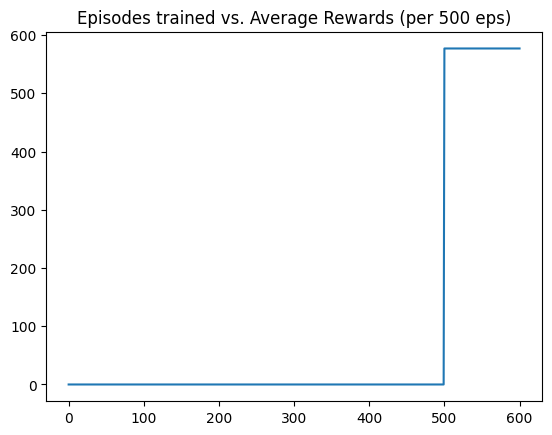

In [9]:
run(training_mode=True, pretrained=False) #400 episodes training
#ignore plot below! 

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during 

Total reward after episode 1 is 1686.0


 20%|██        | 2/10 [03:03<10:22, 77.80s/it] 

Total reward after episode 2 is 632.0


 30%|███       | 3/10 [05:48<13:43, 117.64s/it]

Total reward after episode 3 is 859.0


 40%|████      | 4/10 [06:06<07:49, 78.24s/it] 

Total reward after episode 4 is 609.0


 50%|█████     | 5/10 [06:36<05:04, 60.87s/it]

Total reward after episode 5 is 615.0


 60%|██████    | 6/10 [06:40<02:46, 41.65s/it]

Total reward after episode 6 is 246.0


 70%|███████   | 7/10 [11:36<06:14, 124.68s/it]

Total reward after episode 7 is 980.0


 80%|████████  | 8/10 [11:49<02:58, 89.33s/it] 

Total reward after episode 8 is 629.0


 90%|█████████ | 9/10 [12:14<01:09, 69.12s/it]

Total reward after episode 9 is 637.0


100%|██████████| 10/10 [12:19<00:00, 73.93s/it]

Total reward after episode 10 is 247.0


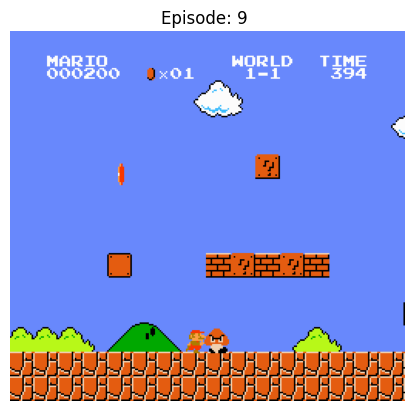

In [12]:
run(training_mode=False, pretrained=True) #400 episodes testing 

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-8-d43ef82177de>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to 

Total reward after episode 1 is 226.0


  0%|          | 2/500 [00:22<1:42:59, 12.41s/it]

Total reward after episode 2 is 633.0


  1%|          | 3/500 [00:27<1:12:47,  8.79s/it]

Total reward after episode 3 is 250.0


  1%|          | 4/500 [00:32<1:00:42,  7.34s/it]

Total reward after episode 4 is 248.0


  1%|          | 5/500 [00:55<1:47:36, 13.04s/it]

Total reward after episode 5 is 602.0


  1%|          | 6/500 [01:30<2:49:41, 20.61s/it]

Total reward after episode 6 is 795.0


  1%|▏         | 7/500 [01:35<2:07:25, 15.51s/it]

Total reward after episode 7 is 231.0


  2%|▏         | 8/500 [01:42<1:42:38, 12.52s/it]

Total reward after episode 8 is 234.0


  2%|▏         | 9/500 [01:47<1:25:30, 10.45s/it]

Total reward after episode 9 is 230.0


  2%|▏         | 10/500 [01:54<1:16:19,  9.35s/it]

Total reward after episode 10 is 231.0


  2%|▏         | 11/500 [02:01<1:08:49,  8.45s/it]

Total reward after episode 11 is 231.0


  2%|▏         | 12/500 [02:07<1:04:13,  7.90s/it]

Total reward after episode 12 is 231.0


  3%|▎         | 13/500 [02:28<1:35:00, 11.71s/it]

Total reward after episode 13 is 584.0


  3%|▎         | 14/500 [02:34<1:21:09, 10.02s/it]

Total reward after episode 14 is 240.0


  3%|▎         | 15/500 [02:55<1:46:42, 13.20s/it]

Total reward after episode 15 is 622.0


  3%|▎         | 16/500 [02:59<1:24:01, 10.42s/it]

Total reward after episode 16 is 248.0


  3%|▎         | 17/500 [03:03<1:10:16,  8.73s/it]

Total reward after episode 17 is 250.0


  4%|▎         | 18/500 [03:07<58:11,  7.24s/it]  

Total reward after episode 18 is 250.0


  4%|▍         | 19/500 [03:11<49:42,  6.20s/it]

Total reward after episode 19 is 250.0


  4%|▍         | 20/500 [03:16<47:17,  5.91s/it]

Total reward after episode 20 is 248.0


  4%|▍         | 21/500 [03:20<42:02,  5.27s/it]

Total reward after episode 21 is 250.0


  4%|▍         | 22/500 [03:32<58:26,  7.33s/it]

Total reward after episode 22 is 642.0


  5%|▍         | 23/500 [03:36<50:14,  6.32s/it]

Total reward after episode 23 is 248.0


  5%|▍         | 24/500 [03:41<46:48,  5.90s/it]

Total reward after episode 24 is 250.0


  5%|▌         | 25/500 [03:45<42:00,  5.31s/it]

Total reward after episode 25 is 248.0


  5%|▌         | 26/500 [03:49<38:37,  4.89s/it]

Total reward after episode 26 is 248.0


  5%|▌         | 27/500 [03:54<38:37,  4.90s/it]

Total reward after episode 27 is 250.0


  6%|▌         | 28/500 [03:58<36:13,  4.61s/it]

Total reward after episode 28 is 251.0


  6%|▌         | 29/500 [04:01<34:31,  4.40s/it]

Total reward after episode 29 is 251.0


  6%|▌         | 30/500 [04:07<35:54,  4.58s/it]

Total reward after episode 30 is 251.0


  6%|▌         | 31/500 [04:10<34:08,  4.37s/it]

Total reward after episode 31 is 250.0


  6%|▋         | 32/500 [04:14<33:07,  4.25s/it]

Total reward after episode 32 is 248.0


  7%|▋         | 33/500 [04:19<34:34,  4.44s/it]

Total reward after episode 33 is 251.0


  7%|▋         | 34/500 [04:23<33:48,  4.35s/it]

Total reward after episode 34 is 248.0


  7%|▋         | 35/500 [04:27<32:51,  4.24s/it]

Total reward after episode 35 is 252.0


  7%|▋         | 36/500 [04:32<34:20,  4.44s/it]

Total reward after episode 36 is 251.0


  7%|▋         | 37/500 [04:36<33:32,  4.35s/it]

Total reward after episode 37 is 250.0


  8%|▊         | 38/500 [04:40<32:42,  4.25s/it]

Total reward after episode 38 is 248.0


  8%|▊         | 39/500 [04:45<33:44,  4.39s/it]

Total reward after episode 39 is 248.0


  8%|▊         | 40/500 [04:50<33:59,  4.43s/it]

Total reward after episode 40 is 240.0


  8%|▊         | 41/500 [04:54<32:59,  4.31s/it]

Total reward after episode 41 is 250.0


  8%|▊         | 42/500 [04:58<33:52,  4.44s/it]

Total reward after episode 42 is 251.0


  9%|▊         | 43/500 [05:03<33:03,  4.34s/it]

Total reward after episode 43 is 251.0


  9%|▉         | 44/500 [05:12<45:33,  6.00s/it]

Total reward after episode 44 is 620.0


  9%|▉         | 45/500 [05:16<40:39,  5.36s/it]

Total reward after episode 45 is 250.0


  9%|▉         | 46/500 [05:21<38:39,  5.11s/it]

Total reward after episode 46 is 250.0


  9%|▉         | 47/500 [05:25<36:06,  4.78s/it]

Total reward after episode 47 is 250.0


 10%|▉         | 48/500 [05:29<34:13,  4.54s/it]

Total reward after episode 48 is 251.0


 10%|▉         | 49/500 [05:33<34:23,  4.58s/it]

Total reward after episode 49 is 250.0


 10%|█         | 50/500 [05:38<33:07,  4.42s/it]

Total reward after episode 50 is 248.0


 10%|█         | 51/500 [05:46<41:30,  5.55s/it]

Total reward after episode 51 is 252.0


 10%|█         | 52/500 [06:33<2:16:02, 18.22s/it]

Total reward after episode 52 is 780.0


 11%|█         | 53/500 [06:38<1:44:51, 14.08s/it]

Total reward after episode 53 is 247.0


 11%|█         | 54/500 [06:49<1:38:33, 13.26s/it]

Total reward after episode 54 is 628.0


 11%|█         | 55/500 [06:53<1:17:24, 10.44s/it]

Total reward after episode 55 is 252.0


 11%|█         | 56/500 [07:12<1:36:12, 13.00s/it]

Total reward after episode 56 is 776.0


 11%|█▏        | 57/500 [07:22<1:29:58, 12.19s/it]

Total reward after episode 57 is 622.0


 12%|█▏        | 58/500 [07:32<1:24:02, 11.41s/it]

Total reward after episode 58 is 622.0


 12%|█▏        | 59/500 [07:42<1:21:52, 11.14s/it]

Total reward after episode 59 is 629.0


 12%|█▏        | 60/500 [07:48<1:09:09,  9.43s/it]

Total reward after episode 60 is 237.0


 12%|█▏        | 61/500 [08:04<1:23:19, 11.39s/it]

Total reward after episode 61 is 620.0


 12%|█▏        | 62/500 [08:23<1:39:20, 13.61s/it]

Total reward after episode 62 is 772.0


 13%|█▎        | 63/500 [08:27<1:18:00, 10.71s/it]

Total reward after episode 63 is 252.0


 13%|█▎        | 64/500 [08:45<1:34:40, 13.03s/it]

Total reward after episode 64 is 819.0


 13%|█▎        | 65/500 [09:03<1:45:04, 14.49s/it]

Total reward after episode 65 is 627.0


 13%|█▎        | 66/500 [09:43<2:39:55, 22.11s/it]

Total reward after episode 66 is 1025.0


 13%|█▎        | 67/500 [09:57<2:21:45, 19.64s/it]

Total reward after episode 67 is 632.0


 14%|█▎        | 68/500 [10:08<2:04:12, 17.25s/it]

Total reward after episode 68 is 622.0


 14%|█▍        | 69/500 [10:47<2:50:41, 23.76s/it]

Total reward after episode 69 is 618.0


 14%|█▍        | 70/500 [10:59<2:23:56, 20.08s/it]

Total reward after episode 70 is 622.0


 14%|█▍        | 71/500 [11:10<2:04:13, 17.38s/it]

Total reward after episode 71 is 620.0


 14%|█▍        | 72/500 [11:15<1:38:03, 13.75s/it]

Total reward after episode 72 is 238.0


 15%|█▍        | 73/500 [11:27<1:34:16, 13.25s/it]

Total reward after episode 73 is 627.0


 15%|█▍        | 74/500 [12:12<2:41:57, 22.81s/it]

Total reward after episode 74 is 1318.0


 15%|█▌        | 75/500 [12:17<2:03:51, 17.49s/it]

Total reward after episode 75 is 239.0


 15%|█▌        | 76/500 [12:31<1:56:13, 16.45s/it]

Total reward after episode 76 is 618.0


 15%|█▌        | 77/500 [12:43<1:45:07, 14.91s/it]

Total reward after episode 77 is 626.0


 16%|█▌        | 78/500 [12:47<1:22:07, 11.68s/it]

Total reward after episode 78 is 251.0


 16%|█▌        | 79/500 [13:07<1:38:58, 14.11s/it]

Total reward after episode 79 is 1066.0


 16%|█▌        | 80/500 [13:45<2:28:41, 21.24s/it]

Total reward after episode 80 is 1327.0


 16%|█▌        | 81/500 [13:56<2:08:38, 18.42s/it]

Total reward after episode 81 is 652.0


 16%|█▋        | 82/500 [14:01<1:38:51, 14.19s/it]

Total reward after episode 82 is 238.0


 17%|█▋        | 83/500 [14:24<1:58:32, 17.06s/it]

Total reward after episode 83 is 599.0


 17%|█▋        | 84/500 [15:14<3:05:23, 26.74s/it]

Total reward after episode 84 is 1305.0


 17%|█▋        | 85/500 [15:41<3:06:49, 27.01s/it]

Total reward after episode 85 is 632.0


 17%|█▋        | 86/500 [16:13<3:14:45, 28.22s/it]

Total reward after episode 86 is 1575.0


 17%|█▋        | 87/500 [17:26<4:47:02, 41.70s/it]

Total reward after episode 87 is 1636.0


 18%|█▊        | 88/500 [18:21<5:13:46, 45.69s/it]

Total reward after episode 88 is 1396.0


 18%|█▊        | 89/500 [18:33<4:03:58, 35.62s/it]

Total reward after episode 89 is 636.0


 18%|█▊        | 90/500 [18:37<2:59:47, 26.31s/it]

Total reward after episode 90 is 236.0


 18%|█▊        | 91/500 [19:05<3:01:44, 26.66s/it]

Total reward after episode 91 is 603.0


 18%|█▊        | 92/500 [19:16<2:28:52, 21.89s/it]

Total reward after episode 92 is 621.0


 19%|█▊        | 93/500 [19:26<2:05:22, 18.48s/it]

Total reward after episode 93 is 615.0


 19%|█▉        | 94/500 [20:04<2:44:03, 24.25s/it]

Total reward after episode 94 is 1333.0


 19%|█▉        | 95/500 [21:07<4:02:09, 35.88s/it]

Total reward after episode 95 is 714.0


 19%|█▉        | 96/500 [21:16<3:07:18, 27.82s/it]

Total reward after episode 96 is 239.0


 19%|█▉        | 97/500 [21:36<2:52:00, 25.61s/it]

Total reward after episode 97 is 592.0


 20%|█▉        | 98/500 [21:53<2:33:19, 22.88s/it]

Total reward after episode 98 is 622.0


 20%|█▉        | 99/500 [22:27<2:55:14, 26.22s/it]

Total reward after episode 99 is 1044.0


 20%|██        | 100/500 [23:10<3:28:14, 31.24s/it]

Total reward after episode 100 is 1323.0


 20%|██        | 101/500 [23:34<3:13:36, 29.11s/it]

Total reward after episode 101 is 739.0


 20%|██        | 102/500 [23:39<2:26:06, 22.03s/it]

Total reward after episode 102 is 240.0


 21%|██        | 103/500 [24:20<3:01:54, 27.49s/it]

Total reward after episode 103 is 793.0


 21%|██        | 104/500 [24:25<2:18:10, 20.93s/it]

Total reward after episode 104 is 242.0


 21%|██        | 105/500 [24:31<1:46:54, 16.24s/it]

Total reward after episode 105 is 237.0


 21%|██        | 106/500 [25:02<2:16:17, 20.76s/it]

Total reward after episode 106 is 808.0


 21%|██▏       | 107/500 [25:16<2:03:14, 18.82s/it]

Total reward after episode 107 is 626.0


 22%|██▏       | 108/500 [25:21<1:36:04, 14.70s/it]

Total reward after episode 108 is 248.0


 22%|██▏       | 109/500 [25:36<1:36:14, 14.77s/it]

Total reward after episode 109 is 611.0


 22%|██▏       | 110/500 [25:41<1:17:00, 11.85s/it]

Total reward after episode 110 is 243.0


 22%|██▏       | 111/500 [25:53<1:16:10, 11.75s/it]

Total reward after episode 111 is 615.0


 22%|██▏       | 112/500 [26:26<1:57:10, 18.12s/it]

Total reward after episode 112 is 1033.0


 23%|██▎       | 113/500 [26:40<1:49:12, 16.93s/it]

Total reward after episode 113 is 649.0


 23%|██▎       | 114/500 [27:02<1:58:23, 18.40s/it]

Total reward after episode 114 is 815.0


 23%|██▎       | 115/500 [27:52<3:00:17, 28.10s/it]

Total reward after episode 115 is 602.0


 23%|██▎       | 116/500 [28:29<3:15:24, 30.53s/it]

Total reward after episode 116 is 722.0


 23%|██▎       | 117/500 [29:03<3:22:41, 31.75s/it]

Total reward after episode 117 is 583.0


 24%|██▎       | 118/500 [29:08<2:30:37, 23.66s/it]

Total reward after episode 118 is 240.0


 24%|██▍       | 119/500 [29:26<2:18:59, 21.89s/it]

Total reward after episode 119 is 1051.0


 24%|██▍       | 120/500 [29:46<2:14:51, 21.29s/it]

Total reward after episode 120 is 1047.0


 24%|██▍       | 121/500 [29:51<1:44:07, 16.48s/it]

Total reward after episode 121 is 239.0


 24%|██▍       | 122/500 [29:55<1:21:11, 12.89s/it]

Total reward after episode 122 is 239.0


 25%|██▍       | 123/500 [30:25<1:51:44, 17.78s/it]

Total reward after episode 123 is 1033.0


 25%|██▍       | 124/500 [30:53<2:10:23, 20.81s/it]

Total reward after episode 124 is 1332.0


 25%|██▌       | 125/500 [30:57<1:38:51, 15.82s/it]

Total reward after episode 125 is 248.0


 25%|██▌       | 126/500 [31:16<1:45:54, 16.99s/it]

Total reward after episode 126 is 781.0


 25%|██▌       | 127/500 [31:27<1:34:01, 15.12s/it]

Total reward after episode 127 is 614.0


 26%|██▌       | 128/500 [31:32<1:14:18, 11.98s/it]

Total reward after episode 128 is 236.0


 26%|██▌       | 129/500 [32:00<1:43:19, 16.71s/it]

Total reward after episode 129 is 808.0


 26%|██▌       | 130/500 [32:25<1:58:25, 19.20s/it]

Total reward after episode 130 is 1040.0


 26%|██▌       | 131/500 [32:36<1:42:54, 16.73s/it]

Total reward after episode 131 is 623.0


 26%|██▋       | 132/500 [32:41<1:22:17, 13.42s/it]

Total reward after episode 132 is 236.0


 27%|██▋       | 133/500 [33:06<1:41:59, 16.67s/it]

Total reward after episode 133 is 1328.0


 27%|██▋       | 134/500 [33:16<1:30:29, 14.84s/it]

Total reward after episode 134 is 613.0


 27%|██▋       | 135/500 [33:42<1:51:00, 18.25s/it]

Total reward after episode 135 is 810.0


 27%|██▋       | 136/500 [34:22<2:30:10, 24.76s/it]

Total reward after episode 136 is 1911.0


 27%|██▋       | 137/500 [34:43<2:22:02, 23.48s/it]

Total reward after episode 137 is 818.0


 28%|██▊       | 138/500 [35:07<2:23:05, 23.72s/it]

Total reward after episode 138 is 742.0


 28%|██▊       | 139/500 [35:33<2:25:53, 24.25s/it]

Total reward after episode 139 is 1347.0


 28%|██▊       | 140/500 [35:42<1:59:16, 19.88s/it]

Total reward after episode 140 is 615.0


 28%|██▊       | 141/500 [36:02<1:57:56, 19.71s/it]

Total reward after episode 141 is 1048.0


 28%|██▊       | 142/500 [36:07<1:31:31, 15.34s/it]

Total reward after episode 142 is 236.0


 29%|██▊       | 143/500 [36:18<1:23:57, 14.11s/it]

Total reward after episode 143 is 608.0


 29%|██▉       | 144/500 [36:40<1:37:40, 16.46s/it]

Total reward after episode 144 is 816.0


 29%|██▉       | 145/500 [37:02<1:48:15, 18.30s/it]

Total reward after episode 145 is 815.0


 29%|██▉       | 146/500 [37:33<2:08:47, 21.83s/it]

Total reward after episode 146 is 805.0


 29%|██▉       | 147/500 [37:37<1:38:16, 16.70s/it]

Total reward after episode 147 is 243.0


 30%|██▉       | 148/500 [38:05<1:58:12, 20.15s/it]

Total reward after episode 148 is 808.0


 30%|██▉       | 149/500 [38:21<1:50:41, 18.92s/it]

Total reward after episode 149 is 609.0


 30%|███       | 150/500 [38:57<2:19:30, 23.92s/it]

Total reward after episode 150 is 798.0


 30%|███       | 151/500 [39:18<2:14:06, 23.06s/it]

Total reward after episode 151 is 625.0


 30%|███       | 152/500 [39:22<1:41:01, 17.42s/it]

Total reward after episode 152 is 248.0


 31%|███       | 153/500 [39:27<1:18:32, 13.58s/it]

Total reward after episode 153 is 248.0


 31%|███       | 154/500 [39:39<1:14:48, 12.97s/it]

Total reward after episode 154 is 636.0


 31%|███       | 155/500 [39:43<1:00:11, 10.47s/it]

Total reward after episode 155 is 251.0


 31%|███       | 156/500 [39:54<1:00:34, 10.57s/it]

Total reward after episode 156 is 620.0


 31%|███▏      | 157/500 [40:25<1:34:59, 16.62s/it]

Total reward after episode 157 is 1335.0


 32%|███▏      | 158/500 [41:19<2:38:45, 27.85s/it]

Total reward after episode 158 is 1304.0


 32%|███▏      | 159/500 [41:52<2:48:13, 29.60s/it]

Total reward after episode 159 is 1927.0


 32%|███▏      | 160/500 [42:47<3:30:35, 37.16s/it]

Total reward after episode 160 is 1830.0


 32%|███▏      | 161/500 [43:30<3:39:32, 38.86s/it]

Total reward after episode 161 is 789.0


 32%|███▏      | 162/500 [44:38<4:27:16, 47.44s/it]

Total reward after episode 162 is 757.0


 33%|███▎      | 163/500 [45:12<4:04:28, 43.53s/it]

Total reward after episode 163 is 740.0


 33%|███▎      | 164/500 [45:45<3:46:50, 40.51s/it]

Total reward after episode 164 is 761.0


 33%|███▎      | 165/500 [45:50<2:45:10, 29.58s/it]

Total reward after episode 165 is 242.0


 33%|███▎      | 166/500 [45:54<2:03:22, 22.16s/it]

Total reward after episode 166 is 245.0


 33%|███▎      | 167/500 [46:16<2:01:47, 21.95s/it]

Total reward after episode 167 is 1329.0


 34%|███▎      | 168/500 [47:11<2:56:08, 31.83s/it]

Total reward after episode 168 is 775.0


 34%|███▍      | 169/500 [47:33<2:39:19, 28.88s/it]

Total reward after episode 169 is 1040.0


 34%|███▍      | 170/500 [47:52<2:23:20, 26.06s/it]

Total reward after episode 170 is 776.0


 34%|███▍      | 171/500 [47:57<1:48:00, 19.70s/it]

Total reward after episode 171 is 251.0


 34%|███▍      | 172/500 [48:02<1:23:20, 15.25s/it]

Total reward after episode 172 is 240.0


 35%|███▍      | 173/500 [48:11<1:13:32, 13.49s/it]

Total reward after episode 173 is 611.0


 35%|███▍      | 174/500 [48:27<1:16:10, 14.02s/it]

Total reward after episode 174 is 636.0


 35%|███▌      | 175/500 [48:36<1:09:18, 12.80s/it]

Total reward after episode 175 is 608.0


 35%|███▌      | 176/500 [48:46<1:03:21, 11.73s/it]

Total reward after episode 176 is 611.0


 35%|███▌      | 177/500 [49:20<1:39:42, 18.52s/it]

Total reward after episode 177 is 611.0


 36%|███▌      | 178/500 [49:32<1:28:59, 16.58s/it]

Total reward after episode 178 is 611.0


 36%|███▌      | 179/500 [49:56<1:40:09, 18.72s/it]

Total reward after episode 179 is 1584.0


 36%|███▌      | 180/500 [50:17<1:44:26, 19.58s/it]

Total reward after episode 180 is 620.0


 36%|███▌      | 181/500 [50:42<1:52:46, 21.21s/it]

Total reward after episode 181 is 597.0


 36%|███▋      | 182/500 [51:08<1:59:46, 22.60s/it]

Total reward after episode 182 is 811.0


 37%|███▋      | 183/500 [51:22<1:45:30, 19.97s/it]

Total reward after episode 183 is 607.0


 37%|███▋      | 184/500 [51:26<1:20:06, 15.21s/it]

Total reward after episode 184 is 251.0


 37%|███▋      | 185/500 [51:39<1:15:26, 14.37s/it]

Total reward after episode 185 is 614.0


 37%|███▋      | 186/500 [52:15<1:50:21, 21.09s/it]

Total reward after episode 186 is 1045.0


 37%|███▋      | 187/500 [52:20<1:24:14, 16.15s/it]

Total reward after episode 187 is 249.0


 38%|███▊      | 188/500 [52:24<1:05:25, 12.58s/it]

Total reward after episode 188 is 251.0


 38%|███▊      | 189/500 [52:53<1:29:32, 17.27s/it]

Total reward after episode 189 is 1927.0


 38%|███▊      | 190/500 [53:06<1:23:05, 16.08s/it]

Total reward after episode 190 is 607.0


 38%|███▊      | 191/500 [53:37<1:45:55, 20.57s/it]

Total reward after episode 191 is 1336.0


 38%|███▊      | 192/500 [54:11<2:06:19, 24.61s/it]

Total reward after episode 192 is 1917.0


 39%|███▊      | 193/500 [54:15<1:34:39, 18.50s/it]

Total reward after episode 193 is 245.0


 39%|███▉      | 194/500 [54:19<1:12:24, 14.20s/it]

Total reward after episode 194 is 242.0


 39%|███▉      | 195/500 [55:04<1:58:16, 23.27s/it]

Total reward after episode 195 is 1866.0


 39%|███▉      | 196/500 [55:14<1:37:45, 19.29s/it]

Total reward after episode 196 is 624.0


 39%|███▉      | 197/500 [55:23<1:22:03, 16.25s/it]

Total reward after episode 197 is 606.0


 40%|███▉      | 198/500 [56:35<2:46:12, 33.02s/it]

Total reward after episode 198 is 980.0


 40%|███▉      | 199/500 [56:55<2:25:39, 29.03s/it]

Total reward after episode 199 is 762.0


 40%|████      | 200/500 [57:30<2:34:58, 31.00s/it]

Total reward after episode 200 is 1918.0


 40%|████      | 201/500 [57:41<2:03:40, 24.82s/it]

Total reward after episode 201 is 624.0


 40%|████      | 202/500 [58:58<3:20:38, 40.40s/it]

Total reward after episode 202 is 1517.0


 41%|████      | 203/500 [59:27<3:04:27, 37.26s/it]

Total reward after episode 203 is 1034.0


 41%|████      | 204/500 [59:38<2:24:13, 29.24s/it]

Total reward after episode 204 is 613.0


 41%|████      | 205/500 [59:50<1:58:45, 24.15s/it]

Total reward after episode 205 is 608.0


 41%|████      | 206/500 [1:00:47<2:46:55, 34.07s/it]

Total reward after episode 206 is 1287.0


 41%|████▏     | 207/500 [1:00:59<2:13:38, 27.37s/it]

Total reward after episode 207 is 600.0


 42%|████▏     | 208/500 [1:01:16<1:57:20, 24.11s/it]

Total reward after episode 208 is 1053.0


 42%|████▏     | 209/500 [1:02:17<2:51:26, 35.35s/it]

Total reward after episode 209 is 1304.0


 42%|████▏     | 210/500 [1:02:21<2:05:30, 25.97s/it]

Total reward after episode 210 is 251.0


 42%|████▏     | 211/500 [1:02:54<2:15:21, 28.10s/it]

Total reward after episode 211 is 1696.0


 42%|████▏     | 212/500 [1:03:19<2:10:27, 27.18s/it]

Total reward after episode 212 is 768.0


 43%|████▎     | 213/500 [1:03:50<2:14:32, 28.13s/it]

Total reward after episode 213 is 805.0


 43%|████▎     | 214/500 [1:04:22<2:19:38, 29.30s/it]

Total reward after episode 214 is 1572.0


 43%|████▎     | 215/500 [1:05:04<2:37:14, 33.10s/it]

Total reward after episode 215 is 1677.0


 43%|████▎     | 216/500 [1:05:27<2:22:34, 30.12s/it]

Total reward after episode 216 is 813.0


 43%|████▎     | 217/500 [1:05:52<2:14:38, 28.55s/it]

Total reward after episode 217 is 1040.0


 44%|████▎     | 218/500 [1:06:03<1:49:36, 23.32s/it]

Total reward after episode 218 is 639.0


 44%|████▍     | 219/500 [1:06:22<1:43:39, 22.13s/it]

Total reward after episode 219 is 733.0


 44%|████▍     | 220/500 [1:06:27<1:19:05, 16.95s/it]

Total reward after episode 220 is 251.0


 44%|████▍     | 221/500 [1:06:38<1:10:27, 15.15s/it]

Total reward after episode 221 is 639.0


 44%|████▍     | 222/500 [1:06:47<1:00:48, 13.12s/it]

Total reward after episode 222 is 608.0


 45%|████▍     | 223/500 [1:07:08<1:11:30, 15.49s/it]

Total reward after episode 223 is 817.0


 45%|████▍     | 224/500 [1:07:21<1:08:26, 14.88s/it]

Total reward after episode 224 is 634.0


 45%|████▌     | 225/500 [1:07:49<1:26:38, 18.90s/it]

Total reward after episode 225 is 765.0


 45%|████▌     | 226/500 [1:08:01<1:16:31, 16.76s/it]

Total reward after episode 226 is 628.0


 45%|████▌     | 227/500 [1:08:32<1:36:13, 21.15s/it]

Total reward after episode 227 is 1927.0


 46%|████▌     | 228/500 [1:08:44<1:22:49, 18.27s/it]

Total reward after episode 228 is 604.0


 46%|████▌     | 229/500 [1:08:56<1:13:34, 16.29s/it]

Total reward after episode 229 is 619.0


 46%|████▌     | 230/500 [1:09:17<1:20:28, 17.88s/it]

Total reward after episode 230 is 817.0


 46%|████▌     | 231/500 [1:09:29<1:11:41, 15.99s/it]

Total reward after episode 231 is 636.0


 46%|████▋     | 232/500 [1:10:52<2:41:16, 36.11s/it]

Total reward after episode 232 is 1499.0


 47%|████▋     | 233/500 [1:11:02<2:06:04, 28.33s/it]

Total reward after episode 233 is 625.0


 47%|████▋     | 234/500 [1:11:06<1:33:24, 21.07s/it]

Total reward after episode 234 is 250.0


 47%|████▋     | 235/500 [1:11:29<1:35:08, 21.54s/it]

Total reward after episode 235 is 757.0


 47%|████▋     | 236/500 [1:12:00<1:47:16, 24.38s/it]

Total reward after episode 236 is 1711.0


 47%|████▋     | 237/500 [1:12:11<1:29:39, 20.45s/it]

Total reward after episode 237 is 639.0


 48%|████▊     | 238/500 [1:12:23<1:17:35, 17.77s/it]

Total reward after episode 238 is 638.0


 48%|████▊     | 239/500 [1:12:28<1:00:28, 13.90s/it]

Total reward after episode 239 is 250.0


 48%|████▊     | 240/500 [1:12:50<1:10:53, 16.36s/it]

Total reward after episode 240 is 778.0


 48%|████▊     | 241/500 [1:13:03<1:06:22, 15.38s/it]

Total reward after episode 241 is 614.0


 48%|████▊     | 242/500 [1:13:15<1:02:36, 14.56s/it]

Total reward after episode 242 is 651.0


 49%|████▊     | 243/500 [1:13:24<54:40, 12.77s/it]  

Total reward after episode 243 is 610.0


 49%|████▉     | 244/500 [1:13:36<53:38, 12.57s/it]

Total reward after episode 244 is 640.0


 49%|████▉     | 245/500 [1:14:10<1:20:21, 18.91s/it]

Total reward after episode 245 is 1029.0


 49%|████▉     | 246/500 [1:14:35<1:28:24, 20.88s/it]

Total reward after episode 246 is 1327.0


 49%|████▉     | 247/500 [1:14:47<1:16:20, 18.10s/it]

Total reward after episode 247 is 634.0


 50%|████▉     | 248/500 [1:15:14<1:27:51, 20.92s/it]

Total reward after episode 248 is 1345.0


 50%|████▉     | 249/500 [1:16:01<2:00:26, 28.79s/it]

Total reward after episode 249 is 1908.0


 50%|█████     | 250/500 [1:16:06<1:29:52, 21.57s/it]

Total reward after episode 250 is 248.0


 50%|█████     | 251/500 [1:16:35<1:39:04, 23.87s/it]

Total reward after episode 251 is 734.0


 50%|█████     | 252/500 [1:16:59<1:37:59, 23.71s/it]

Total reward after episode 252 is 1346.0


 51%|█████     | 253/500 [1:17:11<1:22:57, 20.15s/it]

Total reward after episode 253 is 625.0


 51%|█████     | 254/500 [1:17:32<1:24:41, 20.66s/it]

Total reward after episode 254 is 816.0


 51%|█████     | 255/500 [1:17:55<1:27:04, 21.33s/it]

Total reward after episode 255 is 614.0


 51%|█████     | 256/500 [1:18:19<1:29:44, 22.07s/it]

Total reward after episode 256 is 813.0


 51%|█████▏    | 257/500 [1:18:30<1:15:18, 18.60s/it]

Total reward after episode 257 is 622.0


 52%|█████▏    | 258/500 [1:18:41<1:06:06, 16.39s/it]

Total reward after episode 258 is 623.0


 52%|█████▏    | 259/500 [1:19:14<1:25:59, 21.41s/it]

Total reward after episode 259 is 1325.0


 52%|█████▏    | 260/500 [1:19:38<1:29:07, 22.28s/it]

Total reward after episode 260 is 775.0


 52%|█████▏    | 261/500 [1:20:15<1:46:00, 26.61s/it]

Total reward after episode 261 is 1853.0


 52%|█████▏    | 262/500 [1:20:26<1:26:58, 21.93s/it]

Total reward after episode 262 is 624.0


 53%|█████▎    | 263/500 [1:21:00<1:41:13, 25.63s/it]

Total reward after episode 263 is 1030.0


 53%|█████▎    | 264/500 [1:21:15<1:27:23, 22.22s/it]

Total reward after episode 264 is 606.0


 53%|█████▎    | 265/500 [1:21:58<1:51:58, 28.59s/it]

Total reward after episode 265 is 1413.0


 53%|█████▎    | 266/500 [1:22:35<2:01:02, 31.04s/it]

Total reward after episode 266 is 1915.0


 53%|█████▎    | 267/500 [1:22:46<1:37:27, 25.10s/it]

Total reward after episode 267 is 604.0


 54%|█████▎    | 268/500 [1:22:58<1:21:25, 21.06s/it]

Total reward after episode 268 is 618.0


 54%|█████▍    | 269/500 [1:23:07<1:07:33, 17.55s/it]

Total reward after episode 269 is 611.0


 54%|█████▍    | 270/500 [1:23:28<1:11:28, 18.65s/it]

Total reward after episode 270 is 1041.0


 54%|█████▍    | 271/500 [1:23:43<1:06:49, 17.51s/it]

Total reward after episode 271 is 634.0


 54%|█████▍    | 272/500 [1:24:15<1:23:00, 21.84s/it]

Total reward after episode 272 is 1924.0


 55%|█████▍    | 273/500 [1:24:27<1:11:55, 19.01s/it]

Total reward after episode 273 is 634.0


 55%|█████▍    | 274/500 [1:24:37<1:00:44, 16.12s/it]

Total reward after episode 274 is 608.0


 55%|█████▌    | 275/500 [1:25:15<1:24:58, 22.66s/it]

Total reward after episode 275 is 1020.0


 55%|█████▌    | 276/500 [1:25:37<1:24:36, 22.66s/it]

Total reward after episode 276 is 815.0


 55%|█████▌    | 277/500 [1:25:48<1:11:03, 19.12s/it]

Total reward after episode 277 is 608.0


 56%|█████▌    | 278/500 [1:26:12<1:15:28, 20.40s/it]

Total reward after episode 278 is 1043.0


 56%|█████▌    | 279/500 [1:26:22<1:04:03, 17.39s/it]

Total reward after episode 279 is 614.0


 56%|█████▌    | 280/500 [1:26:26<49:08, 13.40s/it]  

Total reward after episode 280 is 250.0


 56%|█████▌    | 281/500 [1:26:48<58:20, 15.99s/it]

Total reward after episode 281 is 1043.0


 56%|█████▋    | 282/500 [1:27:24<1:19:52, 21.99s/it]

Total reward after episode 282 is 797.0


 57%|█████▋    | 283/500 [1:27:35<1:07:25, 18.64s/it]

Total reward after episode 283 is 608.0


 57%|█████▋    | 284/500 [1:27:45<57:47, 16.05s/it]  

Total reward after episode 284 is 624.0


 57%|█████▋    | 285/500 [1:28:07<1:04:09, 17.91s/it]

Total reward after episode 285 is 814.0


 57%|█████▋    | 286/500 [1:28:18<55:50, 15.66s/it]  

Total reward after episode 286 is 654.0


 57%|█████▋    | 287/500 [1:28:57<1:21:23, 22.93s/it]

Total reward after episode 287 is 1911.0


 58%|█████▊    | 288/500 [1:29:31<1:31:54, 26.01s/it]

Total reward after episode 288 is 1320.0


 58%|█████▊    | 289/500 [1:29:40<1:13:57, 21.03s/it]

Total reward after episode 289 is 611.0


 58%|█████▊    | 290/500 [1:29:45<56:25, 16.12s/it]  

Total reward after episode 290 is 251.0


 58%|█████▊    | 291/500 [1:30:56<1:53:52, 32.69s/it]

Total reward after episode 291 is 1005.0


 58%|█████▊    | 292/500 [1:31:09<1:32:25, 26.66s/it]

Total reward after episode 292 is 621.0


 59%|█████▊    | 293/500 [1:31:36<1:33:05, 26.99s/it]

Total reward after episode 293 is 1324.0


 59%|█████▉    | 294/500 [1:31:48<1:16:41, 22.34s/it]

Total reward after episode 294 is 614.0


 59%|█████▉    | 295/500 [1:32:06<1:12:18, 21.16s/it]

Total reward after episode 295 is 1047.0


 59%|█████▉    | 296/500 [1:32:20<1:04:11, 18.88s/it]

Total reward after episode 296 is 639.0


 59%|█████▉    | 297/500 [1:33:02<1:27:52, 25.98s/it]

Total reward after episode 297 is 1019.0


 60%|█████▉    | 298/500 [1:33:24<1:22:56, 24.64s/it]

Total reward after episode 298 is 1046.0


 60%|█████▉    | 299/500 [1:34:14<1:48:06, 32.27s/it]

Total reward after episode 299 is 1678.0


 60%|██████    | 300/500 [1:34:53<1:54:00, 34.20s/it]

Total reward after episode 300 is 1674.0


 60%|██████    | 301/500 [1:35:04<1:30:41, 27.35s/it]

Total reward after episode 301 is 607.0


 60%|██████    | 302/500 [1:36:14<2:12:01, 40.01s/it]

Total reward after episode 302 is 2329.0


 61%|██████    | 303/500 [1:36:57<2:14:21, 40.92s/it]

Total reward after episode 303 is 730.0


 61%|██████    | 304/500 [1:37:57<2:32:55, 46.81s/it]

Total reward after episode 304 is 1665.0


 61%|██████    | 305/500 [1:38:09<1:57:45, 36.23s/it]

Total reward after episode 305 is 611.0


 61%|██████    | 306/500 [1:38:35<1:47:21, 33.21s/it]

Total reward after episode 306 is 814.0


 61%|██████▏   | 307/500 [1:38:47<1:26:52, 27.01s/it]

Total reward after episode 307 is 637.0


 62%|██████▏   | 308/500 [1:39:18<1:30:02, 28.14s/it]

Total reward after episode 308 is 1342.0


 62%|██████▏   | 309/500 [1:40:28<2:09:11, 40.59s/it]

Total reward after episode 309 is 1298.0


 62%|██████▏   | 310/500 [1:41:11<2:10:53, 41.33s/it]

Total reward after episode 310 is 619.0


 62%|██████▏   | 311/500 [1:41:51<2:09:00, 40.96s/it]

Total reward after episode 311 is 1026.0


 62%|██████▏   | 312/500 [1:42:20<1:56:44, 37.26s/it]

Total reward after episode 312 is 746.0


 63%|██████▎   | 313/500 [1:42:47<1:46:38, 34.21s/it]

Total reward after episode 313 is 813.0


 63%|██████▎   | 314/500 [1:43:12<1:38:00, 31.61s/it]

Total reward after episode 314 is 1041.0


 63%|██████▎   | 315/500 [1:43:46<1:39:00, 32.11s/it]

Total reward after episode 315 is 733.0


 63%|██████▎   | 316/500 [1:44:23<1:43:40, 33.81s/it]

Total reward after episode 316 is 1142.0


 63%|██████▎   | 317/500 [1:44:37<1:24:55, 27.84s/it]

Total reward after episode 317 is 621.0


 64%|██████▎   | 318/500 [1:45:06<1:25:24, 28.16s/it]

Total reward after episode 318 is 636.0


 64%|██████▍   | 319/500 [1:45:34<1:24:41, 28.08s/it]

Total reward after episode 319 is 1043.0


 64%|██████▍   | 320/500 [1:45:47<1:10:47, 23.60s/it]

Total reward after episode 320 is 637.0


 64%|██████▍   | 321/500 [1:46:00<1:00:41, 20.34s/it]

Total reward after episode 321 is 639.0


 64%|██████▍   | 322/500 [1:47:16<1:49:29, 36.91s/it]

Total reward after episode 322 is 2335.0


 65%|██████▍   | 323/500 [1:47:29<1:28:17, 29.93s/it]

Total reward after episode 323 is 622.0


 65%|██████▍   | 324/500 [1:47:39<1:10:31, 24.04s/it]

Total reward after episode 324 is 610.0


 65%|██████▌   | 325/500 [1:47:52<1:00:18, 20.68s/it]

Total reward after episode 325 is 638.0


 65%|██████▌   | 326/500 [1:48:29<1:13:49, 25.46s/it]

Total reward after episode 326 is 1034.0


 65%|██████▌   | 327/500 [1:49:02<1:20:05, 27.78s/it]

Total reward after episode 327 is 1582.0


 66%|██████▌   | 328/500 [1:49:32<1:21:18, 28.37s/it]

Total reward after episode 328 is 1041.0


 66%|██████▌   | 329/500 [1:49:58<1:18:53, 27.68s/it]

Total reward after episode 329 is 620.0


 66%|██████▌   | 330/500 [1:50:12<1:06:27, 23.45s/it]

Total reward after episode 330 is 637.0


 66%|██████▌   | 331/500 [1:50:24<56:57, 20.22s/it]  

Total reward after episode 331 is 639.0


 66%|██████▋   | 332/500 [1:50:53<1:03:48, 22.79s/it]

Total reward after episode 332 is 1345.0


 67%|██████▋   | 333/500 [1:51:18<1:05:15, 23.45s/it]

Total reward after episode 333 is 816.0


 67%|██████▋   | 334/500 [1:51:31<56:07, 20.28s/it]  

Total reward after episode 334 is 641.0


 67%|██████▋   | 335/500 [1:51:41<47:44, 17.36s/it]

Total reward after episode 335 is 611.0


 67%|██████▋   | 336/500 [1:52:05<52:52, 19.34s/it]

Total reward after episode 336 is 1067.0


 67%|██████▋   | 337/500 [1:52:16<45:29, 16.74s/it]

Total reward after episode 337 is 605.0


 68%|██████▊   | 338/500 [1:52:46<55:43, 20.64s/it]

Total reward after episode 338 is 1038.0


 68%|██████▊   | 339/500 [1:53:08<56:40, 21.12s/it]

Total reward after episode 339 is 1045.0


 68%|██████▊   | 340/500 [1:53:38<1:03:43, 23.89s/it]

Total reward after episode 340 is 1040.0


 68%|██████▊   | 341/500 [1:53:50<53:27, 20.18s/it]  

Total reward after episode 341 is 621.0


 68%|██████▊   | 342/500 [1:54:02<46:51, 17.79s/it]

Total reward after episode 342 is 630.0


 69%|██████▊   | 343/500 [1:54:16<43:35, 16.66s/it]

Total reward after episode 343 is 636.0


 69%|██████▉   | 344/500 [1:54:21<33:52, 13.03s/it]

Total reward after episode 344 is 248.0


 69%|██████▉   | 345/500 [1:54:26<27:33, 10.66s/it]

Total reward after episode 345 is 249.0


 69%|██████▉   | 346/500 [1:54:59<45:03, 17.56s/it]

Total reward after episode 346 is 1032.0


 69%|██████▉   | 347/500 [1:55:25<50:36, 19.85s/it]

Total reward after episode 347 is 1346.0


 70%|██████▉   | 348/500 [1:55:29<38:36, 15.24s/it]

Total reward after episode 348 is 240.0


 70%|██████▉   | 349/500 [1:55:51<43:38, 17.34s/it]

Total reward after episode 349 is 816.0


 70%|███████   | 350/500 [1:56:19<51:02, 20.42s/it]

Total reward after episode 350 is 1037.0


 70%|███████   | 351/500 [1:56:24<39:19, 15.84s/it]

Total reward after episode 351 is 242.0


 70%|███████   | 352/500 [1:56:52<48:01, 19.47s/it]

Total reward after episode 352 is 1567.0


 71%|███████   | 353/500 [1:57:15<49:55, 20.38s/it]

Total reward after episode 353 is 1068.0


 71%|███████   | 354/500 [1:57:28<44:32, 18.31s/it]

Total reward after episode 354 is 627.0


 71%|███████   | 355/500 [1:58:01<55:09, 22.82s/it]

Total reward after episode 355 is 1032.0


 71%|███████   | 356/500 [1:58:06<41:18, 17.21s/it]

Total reward after episode 356 is 250.0


 71%|███████▏  | 357/500 [1:58:30<45:50, 19.24s/it]

Total reward after episode 357 is 1041.0


 72%|███████▏  | 358/500 [1:58:42<41:02, 17.34s/it]

Total reward after episode 358 is 620.0


 72%|███████▏  | 359/500 [1:58:57<38:35, 16.42s/it]

Total reward after episode 359 is 613.0


 72%|███████▏  | 360/500 [1:59:09<35:20, 15.15s/it]

Total reward after episode 360 is 622.0


 72%|███████▏  | 361/500 [1:59:30<39:00, 16.84s/it]

Total reward after episode 361 is 1048.0


 72%|███████▏  | 362/500 [1:59:35<30:30, 13.27s/it]

Total reward after episode 362 is 240.0


 73%|███████▎  | 363/500 [2:00:01<39:13, 17.18s/it]

Total reward after episode 363 is 1042.0


 73%|███████▎  | 364/500 [2:00:15<37:06, 16.37s/it]

Total reward after episode 364 is 616.0


 73%|███████▎  | 365/500 [2:00:36<39:26, 17.53s/it]

Total reward after episode 365 is 818.0


 73%|███████▎  | 366/500 [2:01:02<44:48, 20.06s/it]

Total reward after episode 366 is 1152.0


 73%|███████▎  | 367/500 [2:01:14<39:16, 17.72s/it]

Total reward after episode 367 is 637.0


 74%|███████▎  | 368/500 [2:01:25<34:20, 15.61s/it]

Total reward after episode 368 is 618.0


 74%|███████▍  | 369/500 [2:01:38<32:56, 15.09s/it]

Total reward after episode 369 is 638.0


 74%|███████▍  | 370/500 [2:02:05<40:25, 18.66s/it]

Total reward after episode 370 is 1037.0


 74%|███████▍  | 371/500 [2:02:16<35:10, 16.36s/it]

Total reward after episode 371 is 609.0


 74%|███████▍  | 372/500 [2:02:31<33:37, 15.77s/it]

Total reward after episode 372 is 627.0


 75%|███████▍  | 373/500 [2:02:54<37:58, 17.94s/it]

Total reward after episode 373 is 620.0


 75%|███████▍  | 374/500 [2:02:59<29:24, 14.00s/it]

Total reward after episode 374 is 240.0


 75%|███████▌  | 375/500 [2:03:25<36:47, 17.66s/it]

Total reward after episode 375 is 749.0


 75%|███████▌  | 376/500 [2:04:03<49:02, 23.73s/it]

Total reward after episode 376 is 1568.0


 75%|███████▌  | 377/500 [2:04:29<50:26, 24.61s/it]

Total reward after episode 377 is 1345.0


 76%|███████▌  | 378/500 [2:04:41<42:23, 20.85s/it]

Total reward after episode 378 is 612.0


 76%|███████▌  | 379/500 [2:05:03<42:27, 21.05s/it]

Total reward after episode 379 is 1043.0


 76%|███████▌  | 380/500 [2:05:31<46:20, 23.17s/it]

Total reward after episode 380 is 1337.0


 76%|███████▌  | 381/500 [2:05:57<47:27, 23.93s/it]

Total reward after episode 381 is 812.0


 76%|███████▋  | 382/500 [2:06:18<45:18, 23.04s/it]

Total reward after episode 382 is 1044.0


 77%|███████▋  | 383/500 [2:06:32<40:04, 20.55s/it]

Total reward after episode 383 is 612.0


 77%|███████▋  | 384/500 [2:06:53<39:39, 20.51s/it]

Total reward after episode 384 is 1049.0


 77%|███████▋  | 385/500 [2:07:19<42:35, 22.22s/it]

Total reward after episode 385 is 811.0


 77%|███████▋  | 386/500 [2:07:42<42:52, 22.57s/it]

Total reward after episode 386 is 1045.0


 77%|███████▋  | 387/500 [2:07:55<36:50, 19.57s/it]

Total reward after episode 387 is 629.0


 78%|███████▊  | 388/500 [2:08:25<42:26, 22.74s/it]

Total reward after episode 388 is 1340.0


 78%|███████▊  | 389/500 [2:08:30<32:14, 17.43s/it]

Total reward after episode 389 is 252.0


 78%|███████▊  | 390/500 [2:09:10<44:24, 24.22s/it]

Total reward after episode 390 is 1019.0


 78%|███████▊  | 391/500 [2:09:43<48:36, 26.76s/it]

Total reward after episode 391 is 1419.0


 78%|███████▊  | 392/500 [2:10:09<47:59, 26.66s/it]

Total reward after episode 392 is 1039.0


 79%|███████▊  | 393/500 [2:10:30<44:02, 24.70s/it]

Total reward after episode 393 is 1044.0


 79%|███████▉  | 394/500 [2:10:41<36:48, 20.84s/it]

Total reward after episode 394 is 609.0


 79%|███████▉  | 395/500 [2:10:53<31:30, 18.01s/it]

Total reward after episode 395 is 611.0


 79%|███████▉  | 396/500 [2:11:02<26:33, 15.32s/it]

Total reward after episode 396 is 611.0


 79%|███████▉  | 397/500 [2:11:35<35:44, 20.82s/it]

Total reward after episode 397 is 1027.0


 80%|███████▉  | 398/500 [2:12:05<39:58, 23.52s/it]

Total reward after episode 398 is 1430.0


 80%|███████▉  | 399/500 [2:12:25<37:47, 22.45s/it]

Total reward after episode 399 is 1048.0


 80%|████████  | 400/500 [2:12:51<38:56, 23.37s/it]

Total reward after episode 400 is 637.0


 80%|████████  | 401/500 [2:13:01<32:10, 19.50s/it]

Total reward after episode 401 is 618.0


 80%|████████  | 402/500 [2:13:45<43:35, 26.69s/it]

Total reward after episode 402 is 1918.0


 81%|████████  | 403/500 [2:14:22<48:15, 29.85s/it]

Total reward after episode 403 is 1698.0


 81%|████████  | 404/500 [2:14:43<43:27, 27.16s/it]

Total reward after episode 404 is 1048.0


 81%|████████  | 405/500 [2:15:22<48:55, 30.90s/it]

Total reward after episode 405 is 1570.0


 81%|████████  | 406/500 [2:15:27<35:55, 22.93s/it]

Total reward after episode 406 is 248.0


 81%|████████▏ | 407/500 [2:15:50<35:54, 23.17s/it]

Total reward after episode 407 is 1044.0


 82%|████████▏ | 408/500 [2:16:12<34:48, 22.71s/it]

Total reward after episode 408 is 1042.0


 82%|████████▏ | 409/500 [2:16:39<36:10, 23.85s/it]

Total reward after episode 409 is 1039.0


 82%|████████▏ | 410/500 [2:16:50<30:14, 20.16s/it]

Total reward after episode 410 is 636.0


 82%|████████▏ | 411/500 [2:17:09<29:13, 19.71s/it]

Total reward after episode 411 is 1049.0


 82%|████████▏ | 412/500 [2:17:37<32:43, 22.32s/it]

Total reward after episode 412 is 1349.0


 83%|████████▎ | 413/500 [2:18:07<35:40, 24.61s/it]

Total reward after episode 413 is 1324.0


 83%|████████▎ | 414/500 [2:18:40<38:39, 26.97s/it]

Total reward after episode 414 is 1686.0


 83%|████████▎ | 415/500 [2:18:55<33:23, 23.57s/it]

Total reward after episode 415 is 616.0


 83%|████████▎ | 416/500 [2:19:09<28:53, 20.64s/it]

Total reward after episode 416 is 611.0


 83%|████████▎ | 417/500 [2:19:52<37:49, 27.34s/it]

Total reward after episode 417 is 793.0


 84%|████████▎ | 418/500 [2:20:02<30:16, 22.15s/it]

Total reward after episode 418 is 609.0


 84%|████████▍ | 419/500 [2:20:26<30:32, 22.62s/it]

Total reward after episode 419 is 1043.0


 84%|████████▍ | 420/500 [2:20:42<27:23, 20.55s/it]

Total reward after episode 420 is 607.0


 84%|████████▍ | 421/500 [2:20:53<23:33, 17.89s/it]

Total reward after episode 421 is 625.0


 84%|████████▍ | 422/500 [2:21:18<25:47, 19.84s/it]

Total reward after episode 422 is 1040.0


 85%|████████▍ | 423/500 [2:21:42<27:23, 21.35s/it]

Total reward after episode 423 is 753.0


 85%|████████▍ | 424/500 [2:22:09<29:07, 23.00s/it]

Total reward after episode 424 is 1037.0


 85%|████████▌ | 425/500 [2:22:14<21:57, 17.57s/it]

Total reward after episode 425 is 240.0


 85%|████████▌ | 426/500 [2:22:28<20:07, 16.32s/it]

Total reward after episode 426 is 637.0


 85%|████████▌ | 427/500 [2:22:34<16:09, 13.29s/it]

Total reward after episode 427 is 231.0


 86%|████████▌ | 428/500 [2:22:39<12:58, 10.81s/it]

Total reward after episode 428 is 240.0


 86%|████████▌ | 429/500 [2:22:50<13:03, 11.03s/it]

Total reward after episode 429 is 611.0


 86%|████████▌ | 430/500 [2:23:15<17:28, 14.99s/it]

Total reward after episode 430 is 815.0


 86%|████████▌ | 431/500 [2:23:38<20:04, 17.46s/it]

Total reward after episode 431 is 817.0


 86%|████████▋ | 432/500 [2:23:50<17:52, 15.77s/it]

Total reward after episode 432 is 608.0


 87%|████████▋ | 433/500 [2:24:04<17:10, 15.38s/it]

Total reward after episode 433 is 624.0


 87%|████████▋ | 434/500 [2:24:16<15:54, 14.45s/it]

Total reward after episode 434 is 607.0


 87%|████████▋ | 435/500 [2:24:52<22:27, 20.73s/it]

Total reward after episode 435 is 1311.0


 87%|████████▋ | 436/500 [2:25:26<26:23, 24.74s/it]

Total reward after episode 436 is 1571.0


 87%|████████▋ | 437/500 [2:25:47<24:42, 23.53s/it]

Total reward after episode 437 is 1047.0


 88%|████████▊ | 438/500 [2:26:14<25:34, 24.75s/it]

Total reward after episode 438 is 1040.0


 88%|████████▊ | 439/500 [2:26:50<28:36, 28.13s/it]

Total reward after episode 439 is 1425.0


 88%|████████▊ | 440/500 [2:27:22<29:12, 29.21s/it]

Total reward after episode 440 is 1035.0


 88%|████████▊ | 441/500 [2:27:34<23:45, 24.15s/it]

Total reward after episode 441 is 624.0


 88%|████████▊ | 442/500 [2:27:57<22:48, 23.60s/it]

Total reward after episode 442 is 1350.0


 89%|████████▊ | 443/500 [2:28:02<17:09, 18.06s/it]

Total reward after episode 443 is 239.0


 89%|████████▉ | 444/500 [2:28:06<13:05, 14.03s/it]

Total reward after episode 444 is 252.0


 89%|████████▉ | 445/500 [2:28:21<13:01, 14.21s/it]

Total reward after episode 445 is 637.0


 89%|████████▉ | 446/500 [2:28:47<16:06, 17.89s/it]

Total reward after episode 446 is 1345.0


 89%|████████▉ | 447/500 [2:29:13<17:47, 20.15s/it]

Total reward after episode 447 is 1039.0


 90%|████████▉ | 448/500 [2:29:35<18:03, 20.83s/it]

Total reward after episode 448 is 1044.0


 90%|████████▉ | 449/500 [2:29:49<15:51, 18.65s/it]

Total reward after episode 449 is 616.0


 90%|█████████ | 450/500 [2:30:15<17:22, 20.84s/it]

Total reward after episode 450 is 1040.0


 90%|█████████ | 451/500 [2:30:34<16:31, 20.23s/it]

Total reward after episode 451 is 647.0


 90%|█████████ | 452/500 [2:30:57<16:59, 21.24s/it]

Total reward after episode 452 is 1046.0


 91%|█████████ | 453/500 [2:31:09<14:27, 18.45s/it]

Total reward after episode 453 is 609.0


 91%|█████████ | 454/500 [2:31:43<17:34, 22.93s/it]

Total reward after episode 454 is 1334.0


 91%|█████████ | 455/500 [2:31:56<15:08, 20.19s/it]

Total reward after episode 455 is 609.0


 91%|█████████ | 456/500 [2:32:16<14:43, 20.08s/it]

Total reward after episode 456 is 1052.0


 91%|█████████▏| 457/500 [2:32:30<13:05, 18.27s/it]

Total reward after episode 457 is 626.0


 92%|█████████▏| 458/500 [2:32:35<10:02, 14.36s/it]

Total reward after episode 458 is 252.0


 92%|█████████▏| 459/500 [2:32:45<08:52, 12.98s/it]

Total reward after episode 459 is 606.0


 92%|█████████▏| 460/500 [2:32:59<08:43, 13.09s/it]

Total reward after episode 460 is 610.0


 92%|█████████▏| 461/500 [2:33:39<13:55, 21.41s/it]

Total reward after episode 461 is 1854.0


 92%|█████████▏| 462/500 [2:34:02<13:51, 21.88s/it]

Total reward after episode 462 is 1046.0


 93%|█████████▎| 463/500 [2:34:07<10:17, 16.69s/it]

Total reward after episode 463 is 252.0


 93%|█████████▎| 464/500 [2:34:17<08:53, 14.83s/it]

Total reward after episode 464 is 607.0


 93%|█████████▎| 465/500 [2:34:49<11:38, 19.95s/it]

Total reward after episode 465 is 1142.0


 93%|█████████▎| 466/500 [2:35:01<09:52, 17.42s/it]

Total reward after episode 466 is 611.0


 93%|█████████▎| 467/500 [2:35:27<10:56, 19.90s/it]

Total reward after episode 467 is 1039.0


 94%|█████████▎| 468/500 [2:35:41<09:43, 18.23s/it]

Total reward after episode 468 is 630.0


 94%|█████████▍| 469/500 [2:36:09<10:55, 21.13s/it]

Total reward after episode 469 is 1036.0


 94%|█████████▍| 470/500 [2:36:14<08:11, 16.38s/it]

Total reward after episode 470 is 252.0


 94%|█████████▍| 471/500 [2:36:26<07:18, 15.12s/it]

Total reward after episode 471 is 608.0


 94%|█████████▍| 472/500 [2:36:50<08:11, 17.56s/it]

Total reward after episode 472 is 1045.0


 95%|█████████▍| 473/500 [2:37:13<08:39, 19.24s/it]

Total reward after episode 473 is 818.0


 95%|█████████▍| 474/500 [2:37:17<06:27, 14.89s/it]

Total reward after episode 474 is 252.0


 95%|█████████▌| 475/500 [2:37:36<06:42, 16.08s/it]

Total reward after episode 475 is 607.0


 95%|█████████▌| 476/500 [2:37:50<06:06, 15.27s/it]

Total reward after episode 476 is 636.0


 95%|█████████▌| 477/500 [2:38:02<05:30, 14.38s/it]

Total reward after episode 477 is 608.0


 96%|█████████▌| 478/500 [2:38:13<04:54, 13.37s/it]

Total reward after episode 478 is 616.0


 96%|█████████▌| 479/500 [2:38:37<05:45, 16.47s/it]

Total reward after episode 479 is 817.0


 96%|█████████▌| 480/500 [2:38:49<05:02, 15.11s/it]

Total reward after episode 480 is 624.0


 96%|█████████▌| 481/500 [2:40:13<11:20, 35.81s/it]

Total reward after episode 481 is 2324.0


 96%|█████████▋| 482/500 [2:40:25<08:39, 28.83s/it]

Total reward after episode 482 is 613.0


 97%|█████████▋| 483/500 [2:40:43<07:12, 25.45s/it]

Total reward after episode 483 is 603.0


 97%|█████████▋| 484/500 [2:41:29<08:24, 31.56s/it]

Total reward after episode 484 is 793.0


 97%|█████████▋| 485/500 [2:41:41<06:24, 25.65s/it]

Total reward after episode 485 is 626.0


 97%|█████████▋| 486/500 [2:42:04<05:49, 24.99s/it]

Total reward after episode 486 is 1042.0


 97%|█████████▋| 487/500 [2:42:32<05:37, 26.00s/it]

Total reward after episode 487 is 1036.0


 98%|█████████▊| 488/500 [2:42:46<04:27, 22.26s/it]

Total reward after episode 488 is 634.0


 98%|█████████▊| 489/500 [2:42:57<03:27, 18.82s/it]

Total reward after episode 489 is 607.0


 98%|█████████▊| 490/500 [2:43:49<04:50, 29.01s/it]

Total reward after episode 490 is 1908.0


 98%|█████████▊| 491/500 [2:44:18<04:19, 28.88s/it]

Total reward after episode 491 is 1345.0


 98%|█████████▊| 492/500 [2:44:39<03:31, 26.40s/it]

Total reward after episode 492 is 1048.0


 99%|█████████▊| 493/500 [2:45:03<03:01, 25.94s/it]

Total reward after episode 493 is 1053.0


 99%|█████████▉| 494/500 [2:45:16<02:11, 21.84s/it]

Total reward after episode 494 is 608.0


 99%|█████████▉| 495/500 [2:45:42<01:55, 23.18s/it]

Total reward after episode 495 is 1042.0


 99%|█████████▉| 496/500 [2:45:57<01:22, 20.70s/it]

Total reward after episode 496 is 606.0


 99%|█████████▉| 497/500 [2:46:23<01:07, 22.43s/it]

Total reward after episode 497 is 1348.0


100%|█████████▉| 498/500 [2:46:39<00:40, 20.26s/it]

Total reward after episode 498 is 620.0


100%|█████████▉| 499/500 [2:46:52<00:18, 18.22s/it]

Total reward after episode 499 is 607.0


100%|██████████| 500/500 [2:47:28<00:00, 20.10s/it]

Total reward after episode 500 is 1696.0


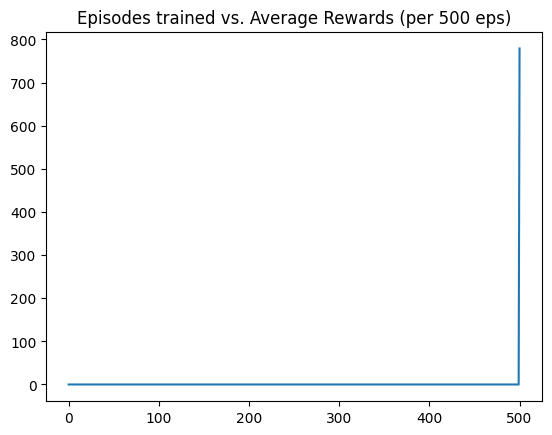

In [9]:
run(training_mode=True, pretrained=False) #500 episodes training 

In [ ]:
#500 episodes testing cell is missing due to Colab not saving it 

In [9]:
run(training_mode=True, pretrained=False) #200 episodes training 

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-8-0df8e68ebe5a>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to 

Total reward after episode 1 is 758.0


  1%|          | 2/200 [01:03<1:42:00, 30.91s/it]

Total reward after episode 2 is 755.0


  2%|▏         | 3/200 [01:08<1:03:02, 19.20s/it]

Total reward after episode 3 is 237.0


  2%|▏         | 4/200 [01:14<45:22, 13.89s/it]  

Total reward after episode 4 is 231.0


  2%|▎         | 5/200 [01:20<35:48, 11.02s/it]

Total reward after episode 5 is 231.0


  3%|▎         | 6/200 [01:25<29:10,  9.02s/it]

Total reward after episode 6 is 231.0


  4%|▎         | 7/200 [01:31<26:11,  8.14s/it]

Total reward after episode 7 is 234.0


  4%|▍         | 8/200 [01:37<23:10,  7.24s/it]

Total reward after episode 8 is 231.0


  4%|▍         | 9/200 [01:43<22:29,  7.06s/it]

Total reward after episode 9 is 231.0


  5%|▌         | 10/200 [01:49<20:52,  6.59s/it]

Total reward after episode 10 is 231.0


  6%|▌         | 11/200 [02:25<49:23, 15.68s/it]

Total reward after episode 11 is 623.0


  6%|▌         | 12/200 [02:29<38:10, 12.18s/it]

Total reward after episode 12 is 246.0


  6%|▋         | 13/200 [03:17<1:11:40, 23.00s/it]

Total reward after episode 13 is 783.0


  7%|▋         | 14/200 [03:22<53:55, 17.40s/it]  

Total reward after episode 14 is 247.0


  8%|▊         | 15/200 [03:27<42:42, 13.85s/it]

Total reward after episode 15 is 247.0


  8%|▊         | 16/200 [03:57<56:43, 18.50s/it]

Total reward after episode 16 is 1036.0


  8%|▊         | 17/200 [04:01<43:30, 14.26s/it]

Total reward after episode 17 is 250.0


  9%|▉         | 18/200 [04:07<35:21, 11.66s/it]

Total reward after episode 18 is 250.0


 10%|▉         | 19/200 [04:11<28:51,  9.57s/it]

Total reward after episode 19 is 251.0


 10%|█         | 20/200 [04:16<24:09,  8.05s/it]

Total reward after episode 20 is 247.0


 10%|█         | 21/200 [04:21<21:35,  7.24s/it]

Total reward after episode 21 is 248.0


 11%|█         | 22/200 [04:26<19:03,  6.43s/it]

Total reward after episode 22 is 251.0


 12%|█▏        | 23/200 [04:31<17:35,  5.96s/it]

Total reward after episode 23 is 251.0


 12%|█▏        | 24/200 [04:36<16:44,  5.71s/it]

Total reward after episode 24 is 250.0


 12%|█▎        | 25/200 [04:40<15:36,  5.35s/it]

Total reward after episode 25 is 252.0


 13%|█▎        | 26/200 [04:46<15:47,  5.44s/it]

Total reward after episode 26 is 247.0


 14%|█▎        | 27/200 [04:51<15:47,  5.48s/it]

Total reward after episode 27 is 237.0


 14%|█▍        | 28/200 [04:56<14:31,  5.07s/it]

Total reward after episode 28 is 251.0


 14%|█▍        | 29/200 [05:01<14:39,  5.14s/it]

Total reward after episode 29 is 249.0


 15%|█▌        | 30/200 [05:05<13:54,  4.91s/it]

Total reward after episode 30 is 250.0


 16%|█▌        | 31/200 [05:10<13:56,  4.95s/it]

Total reward after episode 31 is 252.0


 16%|█▌        | 32/200 [05:15<13:46,  4.92s/it]

Total reward after episode 32 is 249.0


 16%|█▋        | 33/200 [05:19<12:59,  4.67s/it]

Total reward after episode 33 is 251.0


 17%|█▋        | 34/200 [05:24<13:18,  4.81s/it]

Total reward after episode 34 is 248.0


 18%|█▊        | 35/200 [05:29<13:00,  4.73s/it]

Total reward after episode 35 is 248.0


 18%|█▊        | 36/200 [05:33<12:32,  4.59s/it]

Total reward after episode 36 is 249.0


 18%|█▊        | 37/200 [05:38<13:03,  4.81s/it]

Total reward after episode 37 is 248.0


 19%|█▉        | 38/200 [05:43<12:51,  4.76s/it]

Total reward after episode 38 is 251.0


 20%|█▉        | 39/200 [05:47<12:28,  4.65s/it]

Total reward after episode 39 is 249.0


 20%|██        | 40/200 [05:53<12:50,  4.82s/it]

Total reward after episode 40 is 251.0


 20%|██        | 41/200 [05:57<12:19,  4.65s/it]

Total reward after episode 41 is 248.0


 21%|██        | 42/200 [06:01<11:53,  4.52s/it]

Total reward after episode 42 is 248.0


 22%|██▏       | 43/200 [06:07<12:35,  4.81s/it]

Total reward after episode 43 is 247.0


 22%|██▏       | 44/200 [06:11<12:02,  4.63s/it]

Total reward after episode 44 is 248.0


 22%|██▎       | 45/200 [06:15<11:54,  4.61s/it]

Total reward after episode 45 is 248.0


 23%|██▎       | 46/200 [06:20<12:07,  4.73s/it]

Total reward after episode 46 is 248.0


 24%|██▎       | 47/200 [06:25<11:46,  4.62s/it]

Total reward after episode 47 is 250.0


 24%|██▍       | 48/200 [06:30<12:00,  4.74s/it]

Total reward after episode 48 is 251.0


 24%|██▍       | 49/200 [06:35<12:02,  4.79s/it]

Total reward after episode 49 is 252.0


 25%|██▌       | 50/200 [06:39<11:39,  4.66s/it]

Total reward after episode 50 is 250.0


 26%|██▌       | 51/200 [06:44<12:05,  4.87s/it]

Total reward after episode 51 is 248.0


 26%|██▌       | 52/200 [06:49<11:38,  4.72s/it]

Total reward after episode 52 is 250.0


 26%|██▋       | 53/200 [06:53<11:11,  4.57s/it]

Total reward after episode 53 is 249.0


 27%|██▋       | 54/200 [06:58<11:42,  4.81s/it]

Total reward after episode 54 is 248.0


 28%|██▊       | 55/200 [07:03<11:19,  4.69s/it]

Total reward after episode 55 is 249.0


 28%|██▊       | 56/200 [07:07<10:50,  4.52s/it]

Total reward after episode 56 is 248.0


 28%|██▊       | 57/200 [07:12<11:23,  4.78s/it]

Total reward after episode 57 is 249.0


 29%|██▉       | 58/200 [07:17<10:56,  4.62s/it]

Total reward after episode 58 is 252.0


 30%|██▉       | 59/200 [07:22<11:19,  4.82s/it]

Total reward after episode 59 is 242.0


 30%|███       | 60/200 [07:27<11:10,  4.79s/it]

Total reward after episode 60 is 248.0


 30%|███       | 61/200 [07:31<11:03,  4.77s/it]

Total reward after episode 61 is 242.0


 31%|███       | 62/200 [07:37<11:23,  4.95s/it]

Total reward after episode 62 is 248.0


 32%|███▏      | 63/200 [07:41<10:48,  4.74s/it]

Total reward after episode 63 is 248.0


 32%|███▏      | 64/200 [07:45<10:20,  4.56s/it]

Total reward after episode 64 is 251.0


 32%|███▎      | 65/200 [07:50<10:48,  4.80s/it]

Total reward after episode 65 is 248.0


 33%|███▎      | 66/200 [07:55<10:19,  4.62s/it]

Total reward after episode 66 is 248.0


 34%|███▎      | 67/200 [07:59<09:57,  4.50s/it]

Total reward after episode 67 is 248.0


 34%|███▍      | 68/200 [08:04<10:26,  4.75s/it]

Total reward after episode 68 is 248.0


 34%|███▍      | 69/200 [08:14<13:59,  6.41s/it]

Total reward after episode 69 is 619.0


 35%|███▌      | 70/200 [08:19<12:44,  5.88s/it]

Total reward after episode 70 is 252.0


 36%|███▌      | 71/200 [08:23<11:33,  5.37s/it]

Total reward after episode 71 is 248.0


 36%|███▌      | 72/200 [08:28<11:16,  5.28s/it]

Total reward after episode 72 is 248.0


 36%|███▋      | 73/200 [08:33<10:36,  5.01s/it]

Total reward after episode 73 is 248.0


 37%|███▋      | 74/200 [08:37<10:03,  4.79s/it]

Total reward after episode 74 is 248.0


 38%|███▊      | 75/200 [08:43<10:35,  5.09s/it]

Total reward after episode 75 is 241.0


 38%|███▊      | 76/200 [08:47<10:16,  4.97s/it]

Total reward after episode 76 is 238.0


 38%|███▊      | 77/200 [08:52<09:45,  4.76s/it]

Total reward after episode 77 is 248.0


 39%|███▉      | 78/200 [10:08<53:23, 26.26s/it]

Total reward after episode 78 is 749.0


 40%|███▉      | 79/200 [10:13<40:15, 19.96s/it]

Total reward after episode 79 is 248.0


 40%|████      | 80/200 [10:24<34:15, 17.13s/it]

Total reward after episode 80 is 630.0


 40%|████      | 81/200 [10:35<30:32, 15.40s/it]

Total reward after episode 81 is 630.0


 41%|████      | 82/200 [10:41<24:24, 12.41s/it]

Total reward after episode 82 is 248.0


 42%|████▏     | 83/200 [10:45<19:34, 10.03s/it]

Total reward after episode 83 is 252.0


 42%|████▏     | 84/200 [10:50<16:20,  8.45s/it]

Total reward after episode 84 is 238.0


 42%|████▎     | 85/200 [11:19<28:00, 14.61s/it]

Total reward after episode 85 is 633.0


 43%|████▎     | 86/200 [11:30<25:30, 13.42s/it]

Total reward after episode 86 is 627.0


 44%|████▎     | 87/200 [11:35<20:45, 11.02s/it]

Total reward after episode 87 is 249.0


 44%|████▍     | 88/200 [12:04<30:37, 16.41s/it]

Total reward after episode 88 is 1035.0


 44%|████▍     | 89/200 [12:33<37:17, 20.16s/it]

Total reward after episode 89 is 807.0


 45%|████▌     | 90/200 [12:59<40:08, 21.90s/it]

Total reward after episode 90 is 618.0


 46%|████▌     | 91/200 [13:24<41:43, 22.97s/it]

Total reward after episode 91 is 1043.0


 46%|████▌     | 92/200 [13:29<31:42, 17.61s/it]

Total reward after episode 92 is 252.0


 46%|████▋     | 93/200 [13:35<24:55, 13.98s/it]

Total reward after episode 93 is 238.0


 47%|████▋     | 94/200 [13:40<19:50, 11.23s/it]

Total reward after episode 94 is 241.0


 48%|████▊     | 95/200 [13:46<17:05,  9.76s/it]

Total reward after episode 95 is 243.0


 48%|████▊     | 96/200 [13:51<14:12,  8.20s/it]

Total reward after episode 96 is 247.0


 48%|████▊     | 97/200 [14:12<20:36, 12.00s/it]

Total reward after episode 97 is 1047.0


 49%|████▉     | 98/200 [14:17<16:53,  9.94s/it]

Total reward after episode 98 is 243.0


 50%|████▉     | 99/200 [14:21<14:03,  8.35s/it]

Total reward after episode 99 is 250.0


 50%|█████     | 100/200 [14:45<21:34, 12.94s/it]

Total reward after episode 100 is 736.0


 50%|█████     | 101/200 [15:20<32:30, 19.70s/it]

Total reward after episode 101 is 1030.0


 51%|█████     | 102/200 [15:25<24:41, 15.12s/it]

Total reward after episode 102 is 250.0


 52%|█████▏    | 103/200 [15:30<19:49, 12.26s/it]

Total reward after episode 103 is 250.0


 52%|█████▏    | 104/200 [15:36<16:09, 10.10s/it]

Total reward after episode 104 is 243.0


 52%|█████▎    | 105/200 [15:47<16:40, 10.53s/it]

Total reward after episode 105 is 608.0


 53%|█████▎    | 106/200 [15:52<13:49,  8.83s/it]

Total reward after episode 106 is 240.0


 54%|█████▎    | 107/200 [16:40<31:48, 20.52s/it]

Total reward after episode 107 is 1013.0


 54%|█████▍    | 108/200 [16:45<24:16, 15.83s/it]

Total reward after episode 108 is 240.0


 55%|█████▍    | 109/200 [16:50<19:19, 12.75s/it]

Total reward after episode 109 is 253.0


 55%|█████▌    | 110/200 [17:01<18:19, 12.21s/it]

Total reward after episode 110 is 627.0


 56%|█████▌    | 111/200 [17:06<14:39,  9.88s/it]

Total reward after episode 111 is 250.0


 56%|█████▌    | 112/200 [17:10<12:16,  8.36s/it]

Total reward after episode 112 is 243.0


 56%|█████▋    | 113/200 [17:16<10:53,  7.51s/it]

Total reward after episode 113 is 250.0


 57%|█████▋    | 114/200 [17:29<13:21,  9.32s/it]

Total reward after episode 114 is 618.0


 57%|█████▊    | 115/200 [17:34<11:11,  7.90s/it]

Total reward after episode 115 is 247.0


 58%|█████▊    | 116/200 [17:39<09:50,  7.03s/it]

Total reward after episode 116 is 249.0


 58%|█████▊    | 117/200 [18:38<31:14, 22.58s/it]

Total reward after episode 117 is 770.0


 59%|█████▉    | 118/200 [18:42<23:24, 17.13s/it]

Total reward after episode 118 is 250.0


 60%|█████▉    | 119/200 [18:48<18:18, 13.56s/it]

Total reward after episode 119 is 250.0


 60%|██████    | 120/200 [19:00<17:32, 13.15s/it]

Total reward after episode 120 is 638.0


 60%|██████    | 121/200 [19:11<16:26, 12.49s/it]

Total reward after episode 121 is 633.0


 61%|██████    | 122/200 [19:16<13:22, 10.29s/it]

Total reward after episode 122 is 250.0


 62%|██████▏   | 123/200 [19:20<10:56,  8.53s/it]

Total reward after episode 123 is 250.0


 62%|██████▏   | 124/200 [19:26<09:42,  7.67s/it]

Total reward after episode 124 is 246.0


 62%|██████▎   | 125/200 [19:30<08:22,  6.70s/it]

Total reward after episode 125 is 250.0


 63%|██████▎   | 126/200 [19:57<15:29, 12.56s/it]

Total reward after episode 126 is 1154.0


 64%|██████▎   | 127/200 [20:45<28:11, 23.17s/it]

Total reward after episode 127 is 1014.0


 64%|██████▍   | 128/200 [20:49<21:03, 17.55s/it]

Total reward after episode 128 is 250.0


 64%|██████▍   | 129/200 [20:53<16:06, 13.61s/it]

Total reward after episode 129 is 251.0


 65%|██████▌   | 130/200 [20:59<13:06, 11.24s/it]

Total reward after episode 130 is 251.0


 66%|██████▌   | 131/200 [21:03<10:29,  9.12s/it]

Total reward after episode 131 is 247.0


 66%|██████▌   | 132/200 [21:48<22:21, 19.73s/it]

Total reward after episode 132 is 585.0


 66%|██████▋   | 133/200 [21:53<17:09, 15.37s/it]

Total reward after episode 133 is 250.0


 67%|██████▋   | 134/200 [21:57<13:17, 12.08s/it]

Total reward after episode 134 is 250.0


 68%|██████▊   | 135/200 [22:03<11:01, 10.18s/it]

Total reward after episode 135 is 251.0


 68%|██████▊   | 136/200 [22:08<09:01,  8.46s/it]

Total reward after episode 136 is 247.0


 68%|██████▊   | 137/200 [22:36<15:05, 14.38s/it]

Total reward after episode 137 is 1038.0


 69%|██████▉   | 138/200 [22:41<11:56, 11.56s/it]

Total reward after episode 138 is 249.0


 70%|██████▉   | 139/200 [22:46<09:48,  9.65s/it]

Total reward after episode 139 is 248.0


 70%|███████   | 140/200 [22:51<08:17,  8.30s/it]

Total reward after episode 140 is 236.0


 70%|███████   | 141/200 [23:26<15:56, 16.21s/it]

Total reward after episode 141 is 801.0


 71%|███████   | 142/200 [23:30<12:10, 12.59s/it]

Total reward after episode 142 is 250.0


 72%|███████▏  | 143/200 [23:35<09:57, 10.48s/it]

Total reward after episode 143 is 250.0


 72%|███████▏  | 144/200 [23:40<08:07,  8.71s/it]

Total reward after episode 144 is 250.0


 72%|███████▎  | 145/200 [23:44<06:44,  7.35s/it]

Total reward after episode 145 is 250.0


 73%|███████▎  | 146/200 [23:50<06:03,  6.73s/it]

Total reward after episode 146 is 248.0


 74%|███████▎  | 147/200 [23:54<05:15,  5.95s/it]

Total reward after episode 147 is 248.0


 74%|███████▍  | 148/200 [23:58<04:41,  5.41s/it]

Total reward after episode 148 is 248.0


 74%|███████▍  | 149/200 [24:04<04:42,  5.54s/it]

Total reward after episode 149 is 252.0


 75%|███████▌  | 150/200 [24:30<09:44, 11.69s/it]

Total reward after episode 150 is 1040.0


 76%|███████▌  | 151/200 [24:34<07:41,  9.43s/it]

Total reward after episode 151 is 248.0


 76%|███████▌  | 152/200 [24:38<06:22,  7.98s/it]

Total reward after episode 152 is 248.0


 76%|███████▋  | 153/200 [24:44<05:45,  7.34s/it]

Total reward after episode 153 is 240.0


 77%|███████▋  | 154/200 [24:48<04:53,  6.38s/it]

Total reward after episode 154 is 250.0


 78%|███████▊  | 155/200 [25:11<08:21, 11.15s/it]

Total reward after episode 155 is 608.0


 78%|███████▊  | 156/200 [25:51<14:33, 19.85s/it]

Total reward after episode 156 is 1021.0


 78%|███████▊  | 157/200 [26:12<14:34, 20.34s/it]

Total reward after episode 157 is 817.0


 79%|███████▉  | 158/200 [26:17<10:52, 15.55s/it]

Total reward after episode 158 is 248.0


 80%|███████▉  | 159/200 [26:30<10:06, 14.79s/it]

Total reward after episode 159 is 624.0


 80%|████████  | 160/200 [26:59<12:44, 19.11s/it]

Total reward after episode 160 is 1034.0


 80%|████████  | 161/200 [27:17<12:19, 18.95s/it]

Total reward after episode 161 is 1050.0


 81%|████████  | 162/200 [27:22<09:17, 14.68s/it]

Total reward after episode 162 is 251.0


 82%|████████▏ | 163/200 [27:50<11:30, 18.66s/it]

Total reward after episode 163 is 1038.0


 82%|████████▏ | 164/200 [27:54<08:34, 14.30s/it]

Total reward after episode 164 is 251.0


 82%|████████▎ | 165/200 [28:00<06:48, 11.67s/it]

Total reward after episode 165 is 250.0


 83%|████████▎ | 166/200 [28:04<05:21,  9.45s/it]

Total reward after episode 166 is 252.0


 84%|████████▎ | 167/200 [29:13<14:59, 27.25s/it]

Total reward after episode 167 is 1290.0


 84%|████████▍ | 168/200 [29:18<11:03, 20.75s/it]

Total reward after episode 168 is 250.0


 84%|████████▍ | 169/200 [29:23<08:12, 15.89s/it]

Total reward after episode 169 is 244.0


 85%|████████▌ | 170/200 [29:29<06:27, 12.92s/it]

Total reward after episode 170 is 242.0


 86%|████████▌ | 171/200 [29:34<05:05, 10.52s/it]

Total reward after episode 171 is 241.0


 86%|████████▌ | 172/200 [29:38<04:01,  8.61s/it]

Total reward after episode 172 is 249.0


 86%|████████▋ | 173/200 [29:44<03:29,  7.76s/it]

Total reward after episode 173 is 247.0


 87%|████████▋ | 174/200 [30:16<06:36, 15.24s/it]

Total reward after episode 174 is 626.0


 88%|████████▊ | 175/200 [30:22<05:08, 12.33s/it]

Total reward after episode 175 is 252.0


 88%|████████▊ | 176/200 [30:36<05:04, 12.69s/it]

Total reward after episode 176 is 629.0


 88%|████████▊ | 177/200 [30:40<03:55, 10.23s/it]

Total reward after episode 177 is 250.0


 89%|████████▉ | 178/200 [30:45<03:07,  8.50s/it]

Total reward after episode 178 is 250.0


 90%|████████▉ | 179/200 [30:50<02:39,  7.62s/it]

Total reward after episode 179 is 248.0


 90%|█████████ | 180/200 [31:08<03:35, 10.79s/it]

Total reward after episode 180 is 624.0


 90%|█████████ | 181/200 [31:22<03:44, 11.82s/it]

Total reward after episode 181 is 631.0


 91%|█████████ | 182/200 [31:29<03:02, 10.12s/it]

Total reward after episode 182 is 238.0


 92%|█████████▏| 183/200 [31:44<03:20, 11.77s/it]

Total reward after episode 183 is 610.0


 92%|█████████▏| 184/200 [31:49<02:33,  9.57s/it]

Total reward after episode 184 is 250.0


 92%|█████████▎| 185/200 [32:01<02:36, 10.46s/it]

Total reward after episode 185 is 631.0


 93%|█████████▎| 186/200 [32:06<02:03,  8.85s/it]

Total reward after episode 186 is 249.0


 94%|█████████▎| 187/200 [32:53<04:21, 20.14s/it]

Total reward after episode 187 is 1013.0


 94%|█████████▍| 188/200 [33:17<04:15, 21.27s/it]

Total reward after episode 188 is 609.0


 94%|█████████▍| 189/200 [33:21<02:57, 16.18s/it]

Total reward after episode 189 is 250.0


 95%|█████████▌| 190/200 [33:26<02:09, 12.91s/it]

Total reward after episode 190 is 251.0


 96%|█████████▌| 191/200 [33:30<01:32, 10.29s/it]

Total reward after episode 191 is 247.0


 96%|█████████▌| 192/200 [33:35<01:09,  8.69s/it]

Total reward after episode 192 is 236.0


 96%|█████████▋| 193/200 [33:41<00:53,  7.71s/it]

Total reward after episode 193 is 250.0


 97%|█████████▋| 194/200 [33:45<00:39,  6.66s/it]

Total reward after episode 194 is 251.0


 98%|█████████▊| 195/200 [33:50<00:30,  6.03s/it]

Total reward after episode 195 is 247.0


 98%|█████████▊| 196/200 [33:55<00:23,  5.79s/it]

Total reward after episode 196 is 250.0


 98%|█████████▊| 197/200 [34:17<00:31, 10.61s/it]

Total reward after episode 197 is 1045.0


 99%|█████████▉| 198/200 [34:22<00:17,  8.87s/it]

Total reward after episode 198 is 246.0


100%|█████████▉| 199/200 [34:51<00:14, 14.96s/it]

Total reward after episode 199 is 1035.0


100%|██████████| 200/200 [35:38<00:00, 10.69s/it]

Total reward after episode 200 is 1014.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API whic

Total reward after episode 1 is 246.0


 20%|██        | 2/10 [00:12<00:48,  6.12s/it]

Total reward after episode 2 is 243.0


 30%|███       | 3/10 [00:28<01:14, 10.71s/it]

Total reward after episode 3 is 603.0


 40%|████      | 4/10 [00:32<00:49,  8.32s/it]

Total reward after episode 4 is 243.0


 50%|█████     | 5/10 [01:14<01:42, 20.46s/it]

Total reward after episode 5 is 713.0


 60%|██████    | 6/10 [01:41<01:30, 22.65s/it]

Total reward after episode 6 is 634.0


 70%|███████   | 7/10 [02:55<01:58, 39.49s/it]

Total reward after episode 7 is 979.0


 80%|████████  | 8/10 [03:13<01:05, 32.62s/it]

Total reward after episode 8 is 611.0


 90%|█████████ | 9/10 [03:18<00:23, 23.92s/it]

Total reward after episode 9 is 238.0


100%|██████████| 10/10 [05:19<00:00, 31.90s/it]

Total reward after episode 10 is 636.0


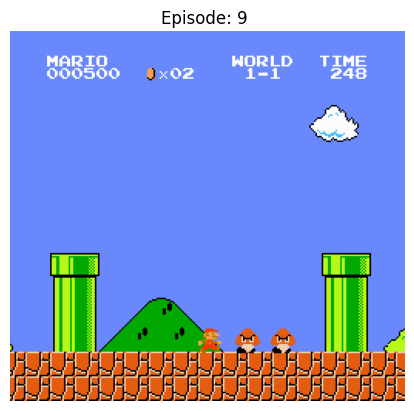

In [12]:
run(training_mode=False, pretrained=True) #200 episodes testing 

In [13]:
#creates and saves a gif of testing stage frames 
import imageio
with imageio.get_writer('200episodes.gif', mode='I') as writer: 
  for filename in filenames: 
    print(filename, end="\r")
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-13-5ad100cd4f72>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [14]:
#deletes testing stage frames once gif is created 
import os
for filename in set(filenames):
    os.remove(filename)